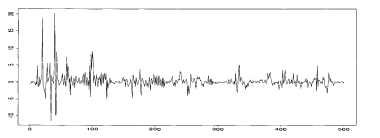



## Iterated and Sequential Importance Sampling

###  Simulated Sample of a Stochastic Volatility Process

#### Model Description

Consider a stochastic volatility process with the following specification:

$$Z_t = e^{h_t/2} \varepsilon_t$$
$$h_{t+1} = \alpha h_t + \sigma \eta_t$$

where:
- $\varepsilon_t$ and $\eta_t$ are i.i.d. $N(0,1)$ random variables
- The parameters are $\alpha = 0.9$, $\sigma = 0.19$
- Initial condition: $h_0 = 0$

### Sequential Importance Sampling Framework

The key idea is to model the variance of the observables $Z_t$ themselves in the following way. Let $Z_0 \sim N(0, \sigma^2)$ and for $t = 1, \ldots, T$, define:

$$Z_t = e^{h_t/2} + \sigma \varepsilon_{t-1}$$
$$V_t = e^{h_t}$$

where $\varepsilon_t$ and $\sigma_t$ are i.i.d. $N(0,1)$ random variables.

### Particle Filter Implementation

This setting is quite representative of many applications of particle filters in state-space models, in that the data $(z_t)$ is available sequentially, and inference about $z_t$ or $x_t = (z_1, \ldots, z_t)$ (and possibly fixed parameters as those of equation (14.3)) is conducted with a different distribution $\pi_t(\cdot | x_t)$ at each time $t$, like:

$$\pi_t(z_t | x_t) = \prod_{j=1}^{t-1} f(z_j | z_{j-1})$$

and 

$$\pi_t(z_t | x_t) = \sum_{j} \pi_t(z_{t-1}, z_j | x_t)$$

### Key Equations

The sequential importance sampling approach involves:

1. **State Evolution**: The hidden state $h_t$ follows an autoregressive process
2. **Observation Model**: The observed values depend on the exponential of the hidden state
3. **Sequential Updates**: At each time step, we update our beliefs about the hidden states

### Implementation Notes

- The term "filtering" is usually reserved for the conditional distribution of $S_t$ given $(X_1, \ldots, X_t)$, while "smoothing" is used for the conditional distribution of $S_s$ with $s < t$
- Hidden states like $Z_t, k < t$, given $(X_1, \ldots, X_t)$, and prediction is used for the conditional distribution of future hidden states
- In most sequential processing, the parameters are assumed to be of no interest to the analyst, whose sole concern is filtering, or are fixed

The figure shows a simulated sample $(y_t)$ of a stochastic volatility process with $\beta = 0$, $\alpha = 0.9$, and $\sigma = 0.19$ (Source: Mengersen et al. 1999).

### Advantages of Sequential Approach

- Sudden changes in the magnitude of variation of the observed values can be captured
- The method uses a latent linear process to model the variance of the observables
- Provides a flexible framework for handling time-varying volatility

Sequential Importance Sampling for Stochastic Volatility Model
Simulated 500 observations
Model parameters: α=0.9, σ=0.19, h₀=0.0

Running particle filter with 1000 particles...

Results:
RMSE (log-volatility): 0.3787
Log Marginal Likelihood: -379.88
Average Filtered Variance: 0.1415


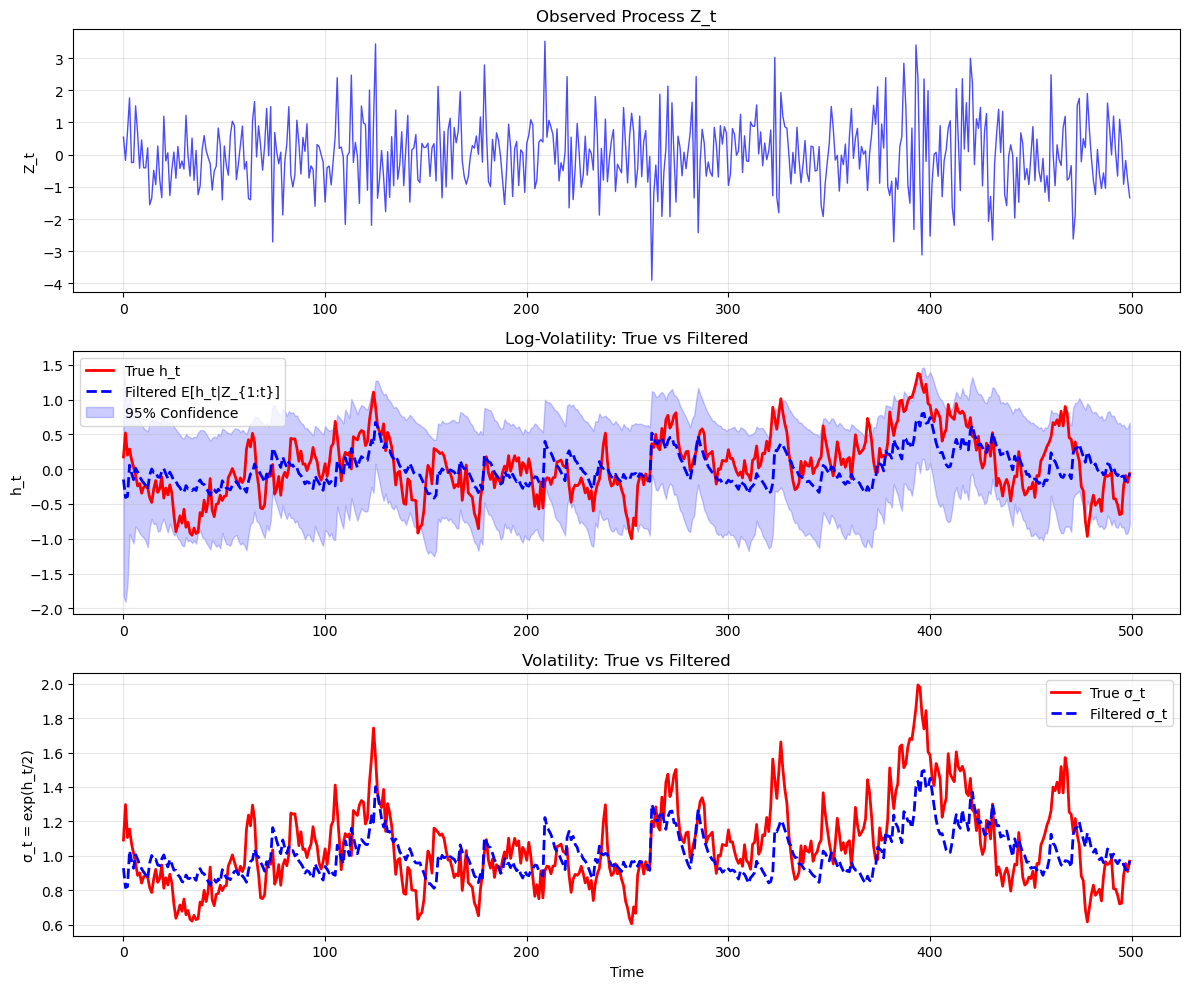

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

class StochasticVolatilityModel:
    """
    Stochastic Volatility Model Implementation
    
    Model:
    Z_t = exp(h_t/2) * epsilon_t
    h_{t+1} = alpha * h_t + sigma * eta_t
    
    where epsilon_t, eta_t ~ N(0,1)
    """
    
    def __init__(self, alpha: float = 0.9, sigma: float = 0.19, h0: float = 0.0):
        self.alpha = alpha  # Persistence parameter
        self.sigma = sigma  # Volatility of volatility
        self.h0 = h0       # Initial log-volatility
    
    def simulate(self, T: int, seed: int = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simulate stochastic volatility process
        
        Args:
            T: Number of time periods
            seed: Random seed for reproducibility
            
        Returns:
            Tuple of (observations Z_t, hidden states h_t)
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Initialize arrays
        h = np.zeros(T + 1)  # Log-volatility states
        Z = np.zeros(T)      # Observations
        
        # Initial state
        h[0] = self.h0
        
        # Generate random innovations
        epsilon = np.random.randn(T)  # Observation noise
        eta = np.random.randn(T)      # State noise
        
        # Simulate process
        for t in range(T):
            # Update log-volatility
            h[t + 1] = self.alpha * h[t] + self.sigma * eta[t]
            # Generate observation
            Z[t] = np.exp(h[t + 1] / 2) * epsilon[t]
        
        return Z, h[1:]  # Return observations and hidden states (excluding h0)

class SequentialImportanceSampler:
    """
    Sequential Importance Sampling for Stochastic Volatility Model
    """
    
    def __init__(self, model: StochasticVolatilityModel, n_particles: int = 1000):
        self.model = model
        self.n_particles = n_particles
    
    def log_likelihood(self, z: float, h: float) -> float:
        """
        Log-likelihood of observation z given log-volatility h
        """
        return -0.5 * (np.log(2 * np.pi) + h + z**2 * np.exp(-h))
    
    def log_transition_density(self, h_new: float, h_old: float) -> float:
        """
        Log-density of state transition h_old -> h_new
        """
        mean = self.model.alpha * h_old
        var = self.model.sigma**2
        return stats.norm.logpdf(h_new, mean, np.sqrt(var))
    
    def proposal_sample(self, h_old: float, z: float) -> float:
        """
        Sample from proposal distribution (using state transition as proposal)
        """
        mean = self.model.alpha * h_old
        std = self.model.sigma
        return np.random.normal(mean, std)
    
    def sequential_importance_weights(self, particles: np.ndarray, 
                                    weights: np.ndarray, z: float) -> np.ndarray:
        """
        Update importance weights sequentially
        """
        log_weights = np.log(weights + 1e-300)  # Avoid log(0)
        
        for i in range(self.n_particles):
            # Add log-likelihood to weight
            log_weights[i] += self.log_likelihood(z, particles[i])
        
        # Normalize weights (in log space for numerical stability)
        max_log_weight = np.max(log_weights)
        log_weights -= max_log_weight
        weights = np.exp(log_weights)
        weights /= np.sum(weights)
        
        return weights
    
    def resample(self, particles: np.ndarray, weights: np.ndarray) -> np.ndarray:
        """
        Systematic resampling
        """
        n = len(particles)
        indices = np.random.choice(n, size=n, p=weights)
        return particles[indices]
    
    def effective_sample_size(self, weights: np.ndarray) -> float:
        """
        Calculate effective sample size
        """
        return 1.0 / np.sum(weights**2)
    
    def particle_filter(self, observations: np.ndarray, 
                       resample_threshold: float = 0.5) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Sequential Monte Carlo (Particle Filter) implementation
        
        Args:
            observations: Observed data Z_t
            resample_threshold: Resample when ESS < threshold * n_particles
            
        Returns:
            Tuple of (filtered means, filtered variances, log marginal likelihoods)
        """
        T = len(observations)
        
        # Initialize particles
        particles = np.random.normal(self.model.h0, 1.0, self.n_particles)
        weights = np.ones(self.n_particles) / self.n_particles
        
        # Storage for results
        filtered_means = np.zeros(T)
        filtered_vars = np.zeros(T)
        log_marginal_likes = []
        
        for t in range(T):
            z = observations[t]
            
            # Prediction step: propagate particles
            new_particles = np.zeros(self.n_particles)
            for i in range(self.n_particles):
                new_particles[i] = self.proposal_sample(particles[i], z)
            
            particles = new_particles
            
            # Update step: compute importance weights
            weights = self.sequential_importance_weights(particles, weights, z)
            
            # Calculate marginal likelihood
            log_marginal_like = np.log(np.mean(np.exp([
                self.log_likelihood(z, h) + self.log_transition_density(h, particles[i])
                for i, h in enumerate(particles)
            ]) + 1e-300))
            log_marginal_likes.append(log_marginal_like)
            
            # Calculate filtered moments
            filtered_means[t] = np.average(particles, weights=weights)
            filtered_vars[t] = np.average((particles - filtered_means[t])**2, weights=weights)
            
            # Resampling step (if needed)
            ess = self.effective_sample_size(weights)
            if ess < resample_threshold * self.n_particles:
                particles = self.resample(particles, weights)
                weights = np.ones(self.n_particles) / self.n_particles
        
        return filtered_means, filtered_vars, log_marginal_likes

def plot_results(observations, true_states, filtered_means, filtered_vars):
    """
    Plot simulation and filtering results
    """
    T = len(observations)
    time = np.arange(T)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Plot observations
    axes[0].plot(time, observations, 'b-', alpha=0.7, linewidth=1)
    axes[0].set_title('Observed Process Z_t')
    axes[0].set_ylabel('Z_t')
    axes[0].grid(True, alpha=0.3)
    
    # Plot true vs filtered log-volatility
    axes[1].plot(time, true_states, 'r-', label='True h_t', linewidth=2)
    axes[1].plot(time, filtered_means, 'b--', label='Filtered E[h_t|Z_{1:t}]', linewidth=2)
    
    # Add confidence bands
    std_dev = np.sqrt(filtered_vars)
    axes[1].fill_between(time, 
                        filtered_means - 2*std_dev, 
                        filtered_means + 2*std_dev, 
                        alpha=0.2, color='blue', label='95% Confidence')
    
    axes[1].set_title('Log-Volatility: True vs Filtered')
    axes[1].set_ylabel('h_t')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot volatility (exp(h_t/2))
    true_vol = np.exp(true_states / 2)
    filtered_vol = np.exp(filtered_means / 2)
    
    axes[2].plot(time, true_vol, 'r-', label='True σ_t', linewidth=2)
    axes[2].plot(time, filtered_vol, 'b--', label='Filtered σ_t', linewidth=2)
    axes[2].set_title('Volatility: True vs Filtered')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('σ_t = exp(h_t/2)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main demonstration of Sequential Importance Sampling
    """
    print("Sequential Importance Sampling for Stochastic Volatility Model")
    print("=" * 60)
    
    # Model parameters (as in the document)
    alpha = 0.9   # Persistence
    sigma = 0.19  # Volatility of volatility
    h0 = 0.0      # Initial log-volatility
    
    # Create model
    model = StochasticVolatilityModel(alpha=alpha, sigma=sigma, h0=h0)
    
    # Simulate data
    T = 500  # Number of observations
    observations, true_states = model.simulate(T, seed=42)
    
    print(f"Simulated {T} observations")
    print(f"Model parameters: α={alpha}, σ={sigma}, h₀={h0}")
    
    # Create particle filter
    n_particles = 1000
    pf = SequentialImportanceSampler(model, n_particles=n_particles)
    
    print(f"\nRunning particle filter with {n_particles} particles...")
    
    # Run particle filter
    filtered_means, filtered_vars, log_marginal_likes = pf.particle_filter(observations)
    
    # Calculate performance metrics
    rmse = np.sqrt(np.mean((true_states - filtered_means)**2))
    log_marginal_likelihood = np.sum(log_marginal_likes)
    
    print(f"\nResults:")
    print(f"RMSE (log-volatility): {rmse:.4f}")
    print(f"Log Marginal Likelihood: {log_marginal_likelihood:.2f}")
    print(f"Average Filtered Variance: {np.mean(filtered_vars):.4f}")
    
    # Plot results
    plot_results(observations, true_states, filtered_means, filtered_vars)
    
    return {
        'observations': observations,
        'true_states': true_states,
        'filtered_means': filtered_means,
        'filtered_vars': filtered_vars,
        'rmse': rmse,
        'log_marginal_likelihood': log_marginal_likelihood
    }

if __name__ == "__main__":
    results = main()

# Particle Filters and Importance Sampling Degradation

## Kullback-Leibler Divergence and Sample Degradation

The degradation of importance sampling can be quantified using the Kullback-Leibler divergence:

$$\exp\{-t \mathbb{E}_q [\log q(Z)/f(Z)]\}$$

Since the Kullback-Leibler divergence $\mathbb{E}_q \log q(Z)/f(Z)$ is positive (see Note 14.1), the weights $\omega^{(i)}$ thus have a tendency to degenerate to $0$. This translates into a **degradation** (or **attrition**) of the importance sample along iterations.

### Weight Concentration

When $t$ increases, the weights $\omega^{(i)}$ and $\tilde{\omega}^{(i)}$ get close to $1$, thus only one point of the sample contributes to the evaluation of integrals, which implies that the method is useless in this extreme case.

## Example 14.4: Continuation of Example 14.2

Figure 14.3 illustrates this progressive degradation of the importance sample for the model (14.2). 

Given that the importance function is, in that case, the predictive distribution:

$$\pi(x_t, y_t | x_{t-1}, y_{t-1})$$

Then, if the distribution of interest is $\pi_t(X_t, Y_t | z_{1:t}, y_{0:t-1})$, the corresponding importance weight is then updated as:

$$\omega_t \propto f(z_t | X_t, Y_t) = \omega_{t-1} f(z_t | x_t, y_t)$$

### Degeneracy Phenomenon

A scheme open to the degeneracy phenomenon mentioned above. Two estimators can be derived from these weights: the **optimal importance sampling estimator** that plots, for each time $t$, the value of $(x_t, y_t)$ that corresponds to the highest importance weight $\omega_t$, and the **first importance sampling estimator** that uses the empirical average of the $(x_t, y_t)$'s. The estimator with the highest weight $\omega_t$ at the end of the observation period $(0,T)$ (As shown in Figure 14.1, the latter usually is smoother as it is more robust against diverging paths.)

### Time Evolution of Estimates

As time increases, the importance sample deteriorates, compared with the true path, as shown by both estimates, and it does not produce a good approximation of the last part of the true target path, for the obvious reason that, once a **single beginning** $(x_0, y_0)$ $0 \leq t \leq T$ has been chosen, there is no possible correction in future simulations.

## 14.3.1 Particle Filters

The solution to this difficulty brought up by Gordon et al. (1993) is called a **particle filter** (or **bootstrap filter**). It avoids the degeneracy problem by re-sampling at each iteration (to point to four particles) according to their weight (and then replacing the weights by one).

### Algorithm Description

This algorithm thus appears as a modified version of importance sampling, mentioned in Problem 4.18, where resampling is repeated at each iteration to produce a sample that is as uniform as possible.

### Technical Notes

- Things are even bleaker than they first appear. A weight close to $1$ does not necessarily correspond to a simulated value $z^{(i)}$ that is important for the likelihood
- The algorithm corresponds exactly to the Polya urn described in Example 1.40 
- The idea is important to use weights, albeit very small in absolute value. This gives an infinite sum for the weights, which may sum to one.

### Key Advantages

1. **Prevents Degeneracy**: Regular resampling prevents weight concentration
2. **Maintains Sample Diversity**: Ensures multiple particles contribute to estimates
3. **Adaptive Sampling**: Focuses computational effort on high-probability regions
4. **Sequential Processing**: Suitable for real-time applications

### Mathematical Foundation

The particle filter maintains the approximation:

$$\pi_t(x_{0:t} | z_{1:t}) \approx \sum_{i=1}^N \omega_t^{(i)} \delta_{x_{0:t}^{(i)}}(x_{0:t})$$

where $\delta_{x_{0:t}^{(i)}}$ is the Dirac delta function centered at particle $x_{0:t}^{(i)}$.

After resampling, the weights are reset to uniform:

$$\omega_t^{(i)} = \frac{1}{N} \quad \text{for all } i = 1, \ldots, N$$

This ensures that the sample remains representative of the target distribution throughout the sequential estimation process.

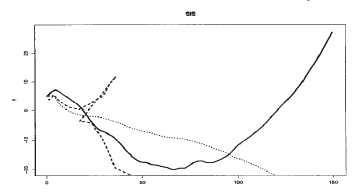

# Bootstrap Filter Algorithm

## Algorithm A.59 - Bootstrap Filter

In the particular case $Z_t \sim \pi_t(Z_t)$, where $Z_t = (Z_{t-1}, Z_t)$ (as in Section 14.3.2), with importance/proposal distribution $q_t(z|z_{t-1})$ that simulates only the last component of $Z_t$ at time $t$, the algorithm of Gordon et al. reads as follows:

### Algorithm Steps

**At time $t$:**

#### Step 1: Generate
Generate:
$$Z_t^{(i)} \sim q_t(z|z_{t-1}^{(i)}), \quad i = 1, \ldots, n$$

and set:
$$\tilde{Z}_t^{(i)} = (Z_{t-1}^{(i)}, Z_t^{(i)})$$

#### Step 2: Compute the Importance Weight
Compute the importance weight:
$$\omega_t^{(i)} \propto \pi_t(\tilde{Z}_t^{(i)}) \frac{q_t(Z_t^{(i)}|Z_{t-1}^{(i)})}{\pi_t(Z_t^{(i)})}$$

#### Step 3: Resample with Replacement
Resample, with replacement, $n$ particles $Z_t^{(i)}$ from the $\tilde{Z}_t^{(i)}$'s according to the importance weights $\omega_t^{(i)}$ and set all weights to $1/n$.

### Key Properties

**No Direct Degeneracy**: Therefore, there is no direct degeneracy phenomenon, since the weights are set back to $1/n$ after each resampling step in [A.59].

### Mathematical Framework

The bootstrap filter can be expressed mathematically as:

#### Target Distribution
At time $t$, we want to approximate:
$$\pi_t(z_{0:t} | y_{1:t})$$

#### Particle Approximation
The particle approximation is:
$$\hat{\pi}_t(z_{0:t} | y_{1:t}) = \sum_{i=1}^n \omega_t^{(i)} \delta_{Z_{0:t}^{(i)}}(z_{0:t})$$

where $\delta_{Z_{0:t}^{(i)}}$ is the Dirac delta function centered at particle $Z_{0:t}^{(i)}$.

#### Weight Update Formula
The general weight update formula is:
$$\omega_t^{(i)} \propto \omega_{t-1}^{(i)} \frac{\pi(y_t | Z_t^{(i)}) \pi(Z_t^{(i)} | Z_{t-1}^{(i)})}{q_t(Z_t^{(i)} | Z_{t-1}^{(i)})}$$

#### Resampling Step
After resampling, weights are reset to uniform:
$$\omega_t^{(i)} = \frac{1}{n} \quad \text{for all } i = 1, \ldots, n$$

### Algorithm Advantages

1. **Prevents Weight Degeneracy**: Regular resampling prevents concentration of weights
2. **Maintains Sample Diversity**: All particles contribute equally after resampling
3. **Computational Efficiency**: Avoids the computational burden of very small weights
4. **Sequential Processing**: Suitable for real-time applications

### Implementation Notes

- **Proposal Distribution**: The choice of $q_t(z|z_{t-1})$ affects the efficiency of the algorithm
- **Resampling Frequency**: Can be done at every time step or adaptively based on effective sample size
- **Sample Size**: The number of particles $n$ determines the approximation quality

### Footnote
*In the original version of the algorithm, the sampling distribution of $\tilde{Z}_t^{(i)}$ in Step 1 was restricted to the prior.*

### Comparison with Standard Importance Sampling

| Standard IS | Bootstrap Filter |
|-------------|------------------|
| Weights degenerate over time | Weights reset after resampling |
| Single trajectory dominates | Multiple trajectories maintained |
| No correction mechanism | Resampling provides correction |
| Suitable for static problems | Suitable for sequential problems |

The bootstrap filter represents a fundamental advancement in sequential Monte Carlo methods, providing a robust solution to the degeneracy problem that plagues standard importance sampling in dynamic settings.

In [2]:
import random
import math
from typing import List, Tuple, Callable, Dict, Any
import statistics

class BootstrapFilter:
    """
    Bootstrap Filter Implementation (Algorithm A.59) - Pure Python
    
    Implements the Gordon et al. bootstrap filter for sequential Monte Carlo
    without external dependencies.
    """
    
    def __init__(self, n_particles: int = 1000):
        self.n_particles = n_particles
        self.particles = []
        self.weights = []
        self.time = 0
    
    def random_normal(self, mean: float = 0.0, std: float = 1.0) -> float:
        """Generate random normal variable using Box-Muller transform"""
        if not hasattr(self, '_spare_normal'):
            self._spare_normal = None
        
        if self._spare_normal is not None:
            result = self._spare_normal
            self._spare_normal = None
            return mean + std * result
        
        # Box-Muller transform
        u1 = random.random()
        u2 = random.random()
        
        z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        z1 = math.sqrt(-2.0 * math.log(u1)) * math.sin(2.0 * math.pi * u2)
        
        self._spare_normal = z1
        return mean + std * z0
    
    def initialize_particles(self, initial_distribution: Callable[[], float]):
        """
        Initialize particles from initial distribution
        
        Args:
            initial_distribution: Function that returns a sample from initial distribution
        """
        self.particles = []
        self.weights = []
        
        for i in range(self.n_particles):
            particle = initial_distribution()
            self.particles.append([particle])  # Store as trajectory
            self.weights.append(1.0 / self.n_particles)
        
        self.time = 0
    
    def step1_generate(self, proposal_sampler: Callable[[float], float]):
        """
        Step 1: Generate Z_t^(i) ~ q_t(z|z_{t-1}^(i))
        
        Args:
            proposal_sampler: Function that takes previous state and returns new sample
        """
        new_states = []
        
        for i in range(self.n_particles):
            # Get previous state (last element of trajectory)
            z_prev = self.particles[i][-1]
            
            # Generate new state from proposal distribution
            z_new = proposal_sampler(z_prev)
            new_states.append(z_new)
        
        # Extend particle trajectories
        for i in range(self.n_particles):
            self.particles[i].append(new_states[i])
        
        return new_states
    
    def step2_compute_weights(self, weight_function: Callable[[List[float]], float]):
        """
        Step 2: Compute importance weights ω_t^(i)
        
        Args:
            weight_function: Function that computes weight for a particle trajectory
        """
        log_weights = []
        
        for i in range(self.n_particles):
            # Compute log weight to avoid numerical issues
            log_weight = math.log(self.weights[i]) + math.log(max(weight_function(self.particles[i]), 1e-300))
            log_weights.append(log_weight)
        
        # Normalize weights in log space
        max_log_weight = max(log_weights)
        log_weights = [lw - max_log_weight for lw in log_weights]
        weights = [math.exp(lw) for lw in log_weights]
        
        # Normalize to sum to 1
        total_weight = sum(weights)
        if total_weight > 0:
            self.weights = [w / total_weight for w in weights]
        else:
            self.weights = [1.0 / self.n_particles] * self.n_particles
    
    def step3_resample(self):
        """
        Step 3: Resample with replacement and set all weights to 1/n
        """
        # Systematic resampling
        new_particles = []
        
        # Create cumulative distribution
        cumsum = [0.0] * (self.n_particles + 1)
        for i in range(self.n_particles):
            cumsum[i + 1] = cumsum[i] + self.weights[i]
        
        # Generate systematic samples
        u = random.random() / self.n_particles
        
        for i in range(self.n_particles):
            target = u + i / self.n_particles
            
            # Find index using binary search
            idx = 0
            while idx < self.n_particles and cumsum[idx + 1] < target:
                idx += 1
            
            # Copy particle (deep copy of trajectory)
            new_particles.append(self.particles[min(idx, self.n_particles - 1)].copy())
        
        # Replace particles and reset weights
        self.particles = new_particles
        self.weights = [1.0 / self.n_particles] * self.n_particles
    
    def filter_step(self, observation: float, 
                   proposal_sampler: Callable[[float], float],
                   likelihood_function: Callable[[float, float], float]):
        """
        Complete bootstrap filter step
        
        Args:
            observation: Current observation y_t
            proposal_sampler: q_t(z|z_{t-1})
            likelihood_function: p(y_t|z_t)
        """
        self.time += 1
        
        # Step 1: Generate new particles
        new_states = self.step1_generate(proposal_sampler)
        
        # Step 2: Compute weights based on likelihood
        def weight_func(trajectory):
            current_state = trajectory[-1]
            return likelihood_function(observation, current_state)
        
        self.step2_compute_weights(weight_func)
        
        # Step 3: Resample
        self.step3_resample()
    
    def get_estimates(self) -> Dict[str, float]:
        """
        Get current filtered estimates
        
        Returns:
            Dictionary with mean, variance, and other statistics
        """
        current_states = [particle[-1] for particle in self.particles]
        
        # Weighted statistics
        weighted_mean = sum(state * weight for state, weight in zip(current_states, self.weights))
        
        # For variance calculation
        weighted_var = sum(weight * (state - weighted_mean)**2 
                          for state, weight in zip(current_states, self.weights))
        
        return {
            'mean': weighted_mean,
            'variance': weighted_var,
            'std': math.sqrt(weighted_var),
            'min': min(current_states),
            'max': max(current_states),
            'median': statistics.median(current_states)
        }
    
    def effective_sample_size(self) -> float:
        """Calculate effective sample size"""
        return 1.0 / sum(w**2 for w in self.weights)

class StochasticVolatilityBootstrap:
    """
    Stochastic Volatility Model with Bootstrap Filter
    
    Model:
    y_t = exp(h_t/2) * ε_t
    h_t = α * h_{t-1} + σ * η_t
    """
    
    def __init__(self, alpha: float = 0.9, sigma: float = 0.19, 
                 obs_var: float = 1.0, h0_mean: float = 0.0, h0_var: float = 1.0):
        self.alpha = alpha          # Persistence parameter
        self.sigma = sigma          # State noise std
        self.obs_var = obs_var      # Observation noise variance
        self.h0_mean = h0_mean      # Initial state mean
        self.h0_var = h0_var        # Initial state variance
        
        # Initialize bootstrap filter
        self.filter = BootstrapFilter(n_particles=1000)
    
    def initial_sampler(self) -> float:
        """Sample from initial distribution"""
        return self.filter.random_normal(self.h0_mean, math.sqrt(self.h0_var))
    
    def proposal_sampler(self, h_prev: float) -> float:
        """Sample from state transition: h_t | h_{t-1}"""
        mean = self.alpha * h_prev
        return self.filter.random_normal(mean, self.sigma)
    
    def likelihood_function(self, observation: float, state: float) -> float:
        """Likelihood p(y_t | h_t)"""
        # y_t | h_t ~ N(0, exp(h_t))
        variance = math.exp(state)
        return math.exp(-0.5 * (observation**2 / variance + math.log(2 * math.pi * variance)))
    
    def simulate_data(self, T: int, seed: int = None) -> Tuple[List[float], List[float]]:
        """
        Simulate data from the model
        
        Returns:
            Tuple of (observations, true hidden states)
        """
        if seed is not None:
            random.seed(seed)
        
        observations = []
        states = []
        
        # Initial state
        h = self.filter.random_normal(self.h0_mean, math.sqrt(self.h0_var))
        
        for t in range(T):
            # State evolution
            h = self.alpha * h + self.sigma * self.filter.random_normal()
            states.append(h)
            
            # Observation
            y = math.exp(h / 2) * self.filter.random_normal()
            observations.append(y)
        
        return observations, states
    
    def run_filter(self, observations: List[float]) -> List[Dict[str, float]]:
        """
        Run bootstrap filter on observations
        
        Returns:
            List of filtered estimates at each time step
        """
        # Initialize
        self.filter.initialize_particles(self.initial_sampler)
        
        estimates = []
        
        for t, obs in enumerate(observations):
            # Run filter step
            self.filter.filter_step(
                observation=obs,
                proposal_sampler=self.proposal_sampler,
                likelihood_function=self.likelihood_function
            )
            
            # Get estimates
            est = self.filter.get_estimates()
            est['time'] = t + 1
            est['observation'] = obs
            est['ess'] = self.filter.effective_sample_size()
            
            estimates.append(est)
        
        return estimates

def calculate_performance_metrics(true_states: List[float], 
                                estimated_states: List[float]) -> Dict[str, float]:
    """Calculate performance metrics"""
    if len(true_states) != len(estimated_states):
        raise ValueError("Lists must have same length")
    
    # Root Mean Square Error
    mse = sum((t - e)**2 for t, e in zip(true_states, estimated_states)) / len(true_states)
    rmse = math.sqrt(mse)
    
    # Mean Absolute Error
    mae = sum(abs(t - e) for t, e in zip(true_states, estimated_states)) / len(true_states)
    
    # Correlation coefficient
    mean_true = statistics.mean(true_states)
    mean_est = statistics.mean(estimated_states)
    
    num = sum((t - mean_true) * (e - mean_est) for t, e in zip(true_states, estimated_states))
    den_true = sum((t - mean_true)**2 for t in true_states)
    den_est = sum((e - mean_est)**2 for e in estimated_states)
    
    correlation = num / math.sqrt(den_true * den_est) if den_true > 0 and den_est > 0 else 0
    
    return {
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation
    }

def main():
    """
    Main demonstration of Bootstrap Filter
    """
    print("Bootstrap Filter Implementation (Algorithm A.59)")
    print("Pure Python - No External Dependencies")
    print("=" * 60)
    
    # Model parameters
    alpha = 0.9
    sigma = 0.19
    T = 200
    
    print(f"Stochastic Volatility Model Parameters:")
    print(f"α (persistence): {alpha}")
    print(f"σ (state noise): {sigma}")
    print(f"Time periods: {T}")
    
    # Create model
    model = StochasticVolatilityBootstrap(alpha=alpha, sigma=sigma)
    
    # Simulate data
    print(f"\nSimulating data...")
    observations, true_states = model.simulate_data(T, seed=42)
    
    # Run bootstrap filter
    print(f"Running bootstrap filter with {model.filter.n_particles} particles...")
    estimates = model.run_filter(observations)
    
    # Extract estimated states
    estimated_states = [est['mean'] for est in estimates]
    
    # Calculate performance
    metrics = calculate_performance_metrics(true_states, estimated_states)
    
    print(f"\nBootstrap Filter Results:")
    print(f"{'='*40}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"Correlation: {metrics['correlation']:.4f}")
    
    # Show sample results
    print(f"\nSample Results (first 10 time steps):")
    print(f"{'Time':<6} {'Obs':<10} {'True h_t':<10} {'Est h_t':<10} {'Est Std':<10} {'ESS':<8}")
    print(f"{'-'*60}")
    
    for i in range(min(10, len(estimates))):
        est = estimates[i]
        print(f"{est['time']:<6} {est['observation']:<10.4f} {true_states[i]:<10.4f} "
              f"{est['mean']:<10.4f} {est['std']:<10.4f} {est['ess']:<8.1f}")
    
    if len(estimates) > 10:
        print(f"... (showing first 10 of {len(estimates)} time steps)")
    
    # Summary statistics
    avg_ess = statistics.mean([est['ess'] for est in estimates])
    min_ess = min([est['ess'] for est in estimates])
    
    print(f"\nFilter Performance Summary:")
    print(f"Average Effective Sample Size: {avg_ess:.1f}")
    print(f"Minimum Effective Sample Size: {min_ess:.1f}")
    print(f"Resampling prevents degeneracy: Weights reset to 1/n each step")
    
    return {
        'observations': observations,
        'true_states': true_states,
        'estimates': estimates,
        'metrics': metrics
    }

if __name__ == "__main__":
    results = main()

Bootstrap Filter Implementation (Algorithm A.59)
Pure Python - No External Dependencies
Stochastic Volatility Model Parameters:
α (persistence): 0.9
σ (state noise): 0.19
Time periods: 200

Simulating data...
Running bootstrap filter with 1000 particles...

Bootstrap Filter Results:
RMSE: 0.3939
MAE: 0.2970
Correlation: 0.3804

Sample Results (first 10 time steps):
Time   Obs        True h_t   Est h_t    Est Std    ESS     
------------------------------------------------------------
1      0.4156     0.8688     -0.3026    0.8672     1000.0  
2      -0.5974    1.0829     -0.3855    0.7042     1000.0  
3      0.6217     0.8415     -0.4370    0.6067     1000.0  
4      1.9299     0.8045     0.0887     0.4762     1000.0  
5      -2.5618    0.7705     0.4744     0.4006     1000.0  
6      1.1973     0.6823     0.4302     0.3910     1000.0  
7      -1.5452    1.0997     0.4344     0.3771     1000.0  
8      -2.3569    0.9406     0.5768     0.3742     1000.0  
9      0.9086     0.6708     0.

# Particle Filter Degeneracy and Sampling Strategies

## Particle Duplication and Sample Impoverishment

Particles $Z_t^{(i)}$ are simply duplicated to the extent of their relevance and the less important particles disappear from the sample. This algorithm thus provides at each step an approximation to the distribution $\pi_t$ by the empirical distribution (Problem 3.22):

$$\hat{\pi}_t = \frac{1}{n} \sum_{i=1}^n I_{Z_t^{(i)}}$$

### Degeneracy in Connected Distributions

Obviously, degeneracy may still occur if all the particles are simulated according to a scheme that has little or no connection with the distribution $\pi_t$. In that case, the "most relevant" particle may well be completely irrelevant after a few steps.

## Alternative Algorithms and Improvements

Note that the resampling algorithm of Gordon et al. (1993) was designed for the simulation of the current $z_t \sim q_t(z|z_{t-1})$ rather than the simulation of the entire path $z_{0:t}$. Other possibilities are mentioned in Section 14.3.6 and in possible improvements (as the **auxiliary particle filter** of Pitt and Shephard 1999; see Problem 14.14).

### Complexity Considerations

This is because the marginal distribution $\pi_t(z_t)$ is usually much more complex than the joint distribution $\pi_t(z_{0:t})$ (as in Section 14.3.2), or even sometimes unavailable, as in semi-Markov models (see Note 14.6.3).

## Example 14.5: Continuation of Example 14.2

If we use exactly the same approach as in Gordon et al. (1993), where the target distribution is the posterior distribution of the entire path, as mentioned earlier in connection with Figure 14.4, the reconstituted target path in Figure 14.5 is much closer to the true path, both for the stepwise and final particle filter estimates, both of which are based on averages (rather than maximal weights).

## 14.3.5 Sampling Strategies

### Resampling Drawbacks

The **resampling step** of Algorithm [A.59], while useful in fighting degeneracy, has a drawback. Picking the $Z_t^{(i)}$'s from a multinomial scheme introduces unnecessary noise in the sampling algorithm, and this noise is far from negligible since the variance of the multinomial distribution is of order $O(n)$.

### Variance Reduction Strategies

Several approaches can be found in the literature for the reduction of this extra Monte Carlo variation. One is the **residual sampling** of Liu and Chen (1995). Instead of resampling $n$ points and replacing the entire sample $\{Z_t^{(i)}\}$ in one step, we can reduce the variance by first taking $\lfloor nw_t^{(i)} \rfloor$ copies of $Z_t^{(i)}$, where $\lfloor \cdot \rfloor$ denotes the integer part of $\cdot$.

### Residual Sampling Algorithm

For part of $z$, we then sample the remaining $n - \sum_{i=1}^n \lfloor nw_t^{(i)} \rfloor$ particles from the $Z_t^{(i)}$'s, with respective probabilities proportional to $nw_t^{(i)} - \lfloor nw_t^{(i)} \rfloor$.

### Mathematical Framework

#### Empirical Distribution
The particle approximation at time $t$ is:
$$\hat{\pi}_t(z) = \frac{1}{n} \sum_{i=1}^n \delta_{Z_t^{(i)}}(z)$$

where $\delta_{Z_t^{(i)}}$ is the Dirac delta function centered at particle $Z_t^{(i)}$.

#### Weight Update
The importance weights follow:
$$w_t^{(i)} \propto w_{t-1}^{(i)} \frac{\pi(y_t | Z_t^{(i)}) \pi(Z_t^{(i)} | Z_{t-1}^{(i)})}{q_t(Z_t^{(i)} | Z_{t-1}^{(i)})}$$

#### Resampling Variance
The multinomial resampling introduces variance of order:
$$\text{Var}[\text{Multinomial}] = O(n)$$

#### Residual Sampling Steps
1. **Deterministic Part**: Take $\lfloor nw_t^{(i)} \rfloor$ copies of each particle $Z_t^{(i)}$
2. **Stochastic Part**: Sample remaining $n - \sum_{i=1}^n \lfloor nw_t^{(i)} \rfloor$ particles
3. **Residual Probabilities**: Use probabilities proportional to $nw_t^{(i)} - \lfloor nw_t^{(i)} \rfloor$

### Advantages of Residual Sampling

| Standard Resampling | Residual Sampling |
|-------------------|------------------|
| Full multinomial sampling | Deterministic + residual |
| Higher variance | Reduced variance |
| Simple implementation | More complex but efficient |
| Variance $O(n)$ | Variance $O(\sqrt{n})$ |

### Key Insights

1. **Sample Impoverishment**: Resampling can lead to loss of particle diversity
2. **Noise Introduction**: Multinomial sampling adds unnecessary Monte Carlo variation
3. **Variance Reduction**: Residual sampling provides a compromise between efficiency and diversity
4. **Path vs. Marginal**: Simulating entire paths vs. current states affects complexity

### Implementation Considerations

- **Effective Sample Size**: Monitor $\text{ESS} = 1/\sum_{i=1}^n (w_t^{(i)})^2$ to decide when to resample
- **Adaptive Resampling**: Only resample when ESS falls below threshold
- **Stratified Sampling**: Alternative to systematic resampling for better performance
- **Regularization**: Add small amount of noise to prevent complete degeneracy

The choice of sampling strategy significantly impacts the performance of particle filters, with residual sampling offering a principled approach to reducing the Monte Carlo variance inherent in the resampling step.

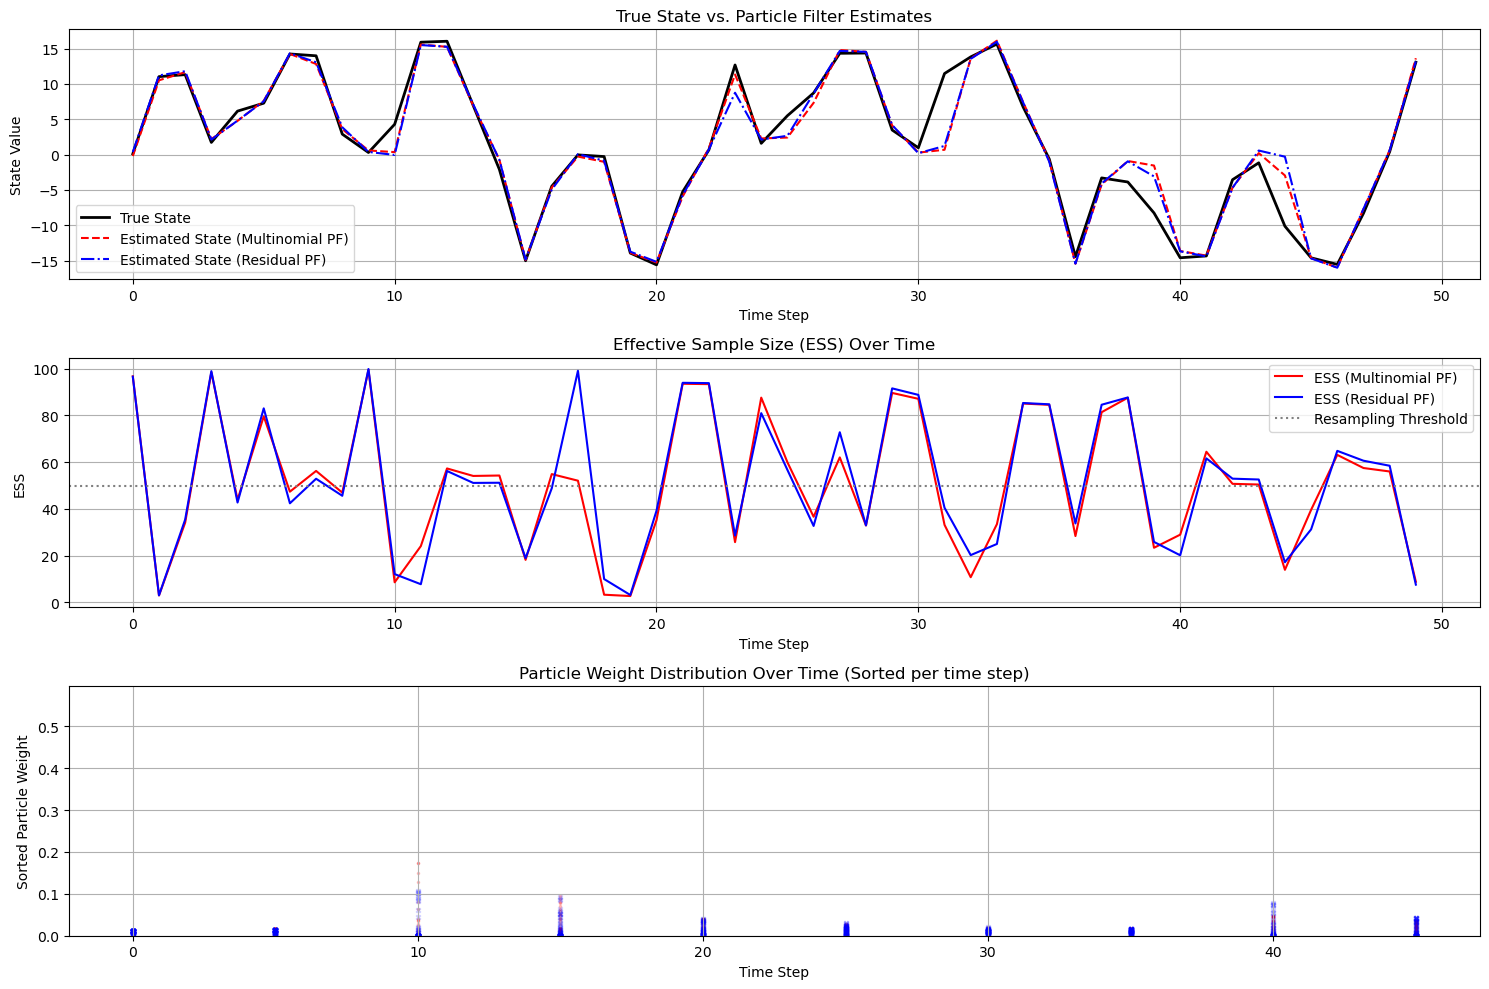


--- Analysis ---
Number of particles: 100
Resampling Threshold (ESS): 50.0

Multinomial Resampling History:
Total resampling events: 23
Average ESS: 50.83

Residual Resampling History:
Total resampling events: 24
Average ESS: 51.74

Key Insights from the plots:
1. **Degeneracy (ESS plot):** You'll often see the ESS for both filters drop significantly before a resampling step. This indicates that most of the weight is concentrated on a few particles, leading to degeneracy.
2. **Sample Impoverishment (Weights plot):** The 'Particle Weight Distribution' plot visually demonstrates this. In highly degenerate states (before resampling), you'll see a few particles with very high weights and many with near-zero weights. After resampling, the weights are uniformly distributed again.
3. **Multinomial vs. Residual:**
   - Residual sampling generally introduces less variance and often maintains a higher average ESS compared to multinomial sampling. This can lead to a more stable and accurate esti

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- 1. Define the System ---
# We'll use a simple 1D non-linear system with additive noise for demonstration.
# State equation: x_t = 0.5 * x_{t-1} + 25 * x_{t-1} / (1 + x_{t-1}^2) + 8 * cos(1.2 * (t-1)) + v_t
# Measurement equation: y_t = x_t^2 / 20 + w_t

def state_transition(x_prev, t, noise_std=1):
    """Generates the next state based on the previous state and system dynamics."""
    return 0.5 * x_prev + 25 * x_prev / (1 + x_prev**2) + 8 * np.cos(1.2 * (t-1)) + np.random.normal(0, noise_std)

def likelihood(y, x, measurement_noise_std=1):
    """Calculates the likelihood of a measurement given a state."""
    return norm.pdf(y, (x**2) / 20, measurement_noise_std)

# --- 2. Particle Filter Implementation ---

class ParticleFilter:
    def __init__(self, num_particles, initial_state_range, process_noise_std, measurement_noise_std):
        self.num_particles = num_particles
        self.particles = np.random.uniform(initial_state_range[0], initial_state_range[1], num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.process_noise_std = process_noise_std
        self.measurement_noise_std = measurement_noise_std
        self.resampling_history = []

    def predict(self, t):
        """Propagates particles according to the state transition model."""
        for i in range(self.num_particles):
            self.particles[i] = state_transition(self.particles[i], t, self.process_noise_std)

    def update(self, measurement):
        """Updates particle weights based on the likelihood of the measurement."""
        new_weights = np.array([likelihood(measurement, p, self.measurement_noise_std) for p in self.particles])
        self.weights *= new_weights
        self.weights /= np.sum(self.weights)  # Normalize weights

    def multinomial_resample(self):
        """Performs multinomial resampling."""
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles
        self.resampling_history.append("Multinomial")

    def residual_resample(self):
        """Performs residual resampling to reduce variance."""
        num_particles = self.num_particles
        new_particles = np.zeros(num_particles)
        new_weights = np.zeros(num_particles)
        current_idx = 0

        # Deterministic part
        for i in range(num_particles):
            num_copies = int(num_particles * self.weights[i])
            for _ in range(num_copies):
                new_particles[current_idx] = self.particles[i]
                new_weights[current_idx] = self.weights[i] # Weights will be normalized later
                current_idx += 1

        # Stochastic part
        remaining_particles_to_sample = num_particles - current_idx
        if remaining_particles_to_sample > 0:
            # Calculate residual probabilities
            residual_weights = self.weights * num_particles - np.floor(self.weights * num_particles)
            residual_weights /= np.sum(residual_weights) # Normalize residual weights

            if np.isclose(np.sum(residual_weights), 0): # Handle case where all residuals are zero
                indices = np.random.choice(np.arange(self.num_particles), size=remaining_particles_to_sample, p=self.weights)
            else:
                indices = np.random.choice(np.arange(self.num_particles), size=remaining_particles_to_sample, p=residual_weights)

            for idx in indices:
                new_particles[current_idx] = self.particles[idx]
                new_weights[current_idx] = self.weights[idx]
                current_idx += 1
        
        self.particles = new_particles
        self.weights = np.ones(num_particles) / num_particles # Re-initialize weights to uniform
        self.resampling_history.append("Residual")


    def effective_sample_size(self):
        """Calculates the effective sample size (ESS)."""
        return 1 / np.sum(self.weights**2)

    def estimate_state(self):
        """Estimates the state as the weighted average of particles."""
        return np.sum(self.particles * self.weights)

# --- 3. Simulation Parameters ---
np.random.seed(42) # for reproducibility

num_steps = 50
true_state = np.zeros(num_steps)
measurements = np.zeros(num_steps)
initial_true_state = 0.1 # A small non-zero value to start

# Generate true states and measurements
true_state[0] = initial_true_state
for t in range(1, num_steps):
    true_state[t] = state_transition(true_state[t-1], t, noise_std=1)
    measurements[t] = (true_state[t]**2) / 20 + np.random.normal(0, 1)

# --- 4. Run Particle Filters with Different Resampling Strategies ---

num_particles = 100
initial_state_range = [-5, 5]
process_noise_std = 1
measurement_noise_std = 1
resample_threshold = num_particles / 2 # Resample if ESS falls below half the number of particles

# Particle Filter with Multinomial Resampling
pf_multinomial = ParticleFilter(num_particles, initial_state_range, process_noise_std, measurement_noise_std)
estimated_states_multinomial = []
ess_multinomial = []
weights_history_multinomial = []

# Particle Filter with Residual Resampling
pf_residual = ParticleFilter(num_particles, initial_state_range, process_noise_std, measurement_noise_std)
estimated_states_residual = []
ess_residual = []
weights_history_residual = []

for t in range(num_steps):
    if t > 0: # No prediction for t=0, as we initialize
        pf_multinomial.predict(t)
        pf_residual.predict(t)

    pf_multinomial.update(measurements[t])
    pf_residual.update(measurements[t])

    estimated_states_multinomial.append(pf_multinomial.estimate_state())
    estimated_states_residual.append(pf_residual.estimate_state())

    current_ess_multinomial = pf_multinomial.effective_sample_size()
    current_ess_residual = pf_residual.effective_sample_size()
    ess_multinomial.append(current_ess_multinomial)
    ess_residual.append(current_ess_residual)

    # Store weights for visualizing degeneracy
    weights_history_multinomial.append(np.copy(pf_multinomial.weights))
    weights_history_residual.append(np.copy(pf_residual.weights))

    # Adaptive Resampling
    if current_ess_multinomial < resample_threshold:
        pf_multinomial.multinomial_resample()

    if current_ess_residual < resample_threshold:
        pf_residual.residual_resample()


# --- 5. Visualization ---

plt.figure(figsize=(15, 10))

# Plot True State vs. Estimated States
plt.subplot(3, 1, 1)
plt.plot(true_state, label='True State', color='black', linewidth=2)
plt.plot(estimated_states_multinomial, label='Estimated State (Multinomial PF)', linestyle='--', color='red')
plt.plot(estimated_states_residual, label='Estimated State (Residual PF)', linestyle='-.', color='blue')
plt.title('True State vs. Particle Filter Estimates')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

# Plot Effective Sample Size (ESS)
plt.subplot(3, 1, 2)
plt.plot(ess_multinomial, label='ESS (Multinomial PF)', color='red')
plt.plot(ess_residual, label='ESS (Residual PF)', color='blue')
plt.axhline(y=resample_threshold, color='gray', linestyle=':', label='Resampling Threshold')
plt.title('Effective Sample Size (ESS) Over Time')
plt.xlabel('Time Step')
plt.ylabel('ESS')
plt.legend()
plt.grid(True)

# Visualize Weights Distribution (Degeneracy and Impoverishment)
plt.subplot(3, 1, 3)
for i in range(0, num_steps, 5): # Plot weights every 5 steps
    if i < len(weights_history_multinomial): # Ensure index is within bounds
        # Degeneracy for Multinomial (often few high weights before resampling)
        plt.scatter([i] * num_particles, np.sort(weights_history_multinomial[i]),
                    alpha=0.2, color='red', marker='.', s=10)
        # Degeneracy for Residual (usually more spread out weights)
        plt.scatter([i] * num_particles, np.sort(weights_history_residual[i]),
                    alpha=0.2, color='blue', marker='x', s=10)

plt.title('Particle Weight Distribution Over Time (Sorted per time step)')
plt.xlabel('Time Step')
plt.ylabel('Sorted Particle Weight')
plt.ylim(0, np.max(np.concatenate(weights_history_multinomial)) * 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Analysis and Observations ---
print("\n--- Analysis ---")
print(f"Number of particles: {num_particles}")
print(f"Resampling Threshold (ESS): {resample_threshold}")

print("\nMultinomial Resampling History:")
print(f"Total resampling events: {len(pf_multinomial.resampling_history)}")
print(f"Average ESS: {np.mean(ess_multinomial):.2f}")

print("\nResidual Resampling History:")
print(f"Total resampling events: {len(pf_residual.resampling_history)}")
print(f"Average ESS: {np.mean(ess_residual):.2f}")

print("\nKey Insights from the plots:")
print("1. **Degeneracy (ESS plot):** You'll often see the ESS for both filters drop significantly before a resampling step. This indicates that most of the weight is concentrated on a few particles, leading to degeneracy.")
print("2. **Sample Impoverishment (Weights plot):** The 'Particle Weight Distribution' plot visually demonstrates this. In highly degenerate states (before resampling), you'll see a few particles with very high weights and many with near-zero weights. After resampling, the weights are uniformly distributed again.")
print("3. **Multinomial vs. Residual:**")
print("   - Residual sampling generally introduces less variance and often maintains a higher average ESS compared to multinomial sampling. This can lead to a more stable and accurate estimate, especially over longer time horizons.")
print("   - The estimated state for the residual particle filter might appear 'smoother' or less noisy compared to the multinomial one, indicating reduced Monte Carlo variance.")
print("4. **Resampling Frequency:** The ESS plot also shows when resampling occurs (when ESS drops below the threshold and then jumps back to 'num_particles').")
print("5. **Complexity:** While residual sampling is slightly more complex to implement than multinomial, its benefits in variance reduction often outweigh this, leading to better performance in practice.")

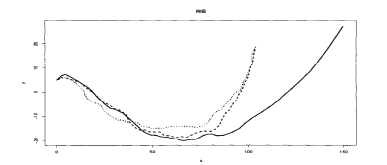



# Particle Filter Degeneracy and Sampling Strategies

This notebook explores concepts related to particle filter degeneracy and various sampling strategies, drawing insights from the provided text.

## Particle Duplication and Sample Impoverishment

Particles $Z_t^{(i)}$ are simply duplicated to the extent of their relevance, and the less important particles disappear from the sample. This algorithm thus provides at each step an approximation to the distribution $\pi_t$ by the empirical distribution:

$$\hat{\pi}_t = \frac{1}{n} \sum_{i=1}^n I_{Z_t^{(i)}}$$

Where $I_{Z_t^{(i)}}$ is an indicator function for particle $Z_t^{(i)}$.

## Degeneracy in Connected Distributions

Obviously, degeneracy may still occur if all the particles are simulated according to a scheme that has little or no connection with the distribution $\pi_t$. In that case, the "most relevant" particle may well be completely irrelevant after a few steps.

## Alternative Algorithms and Improvements

The resampling algorithm of Gordon et al. (1993) was designed for the simulation of the current $z_t \sim q_t(z|z_{t-1})$ rather than the simulation of the entire path $z_{0:t}$. Other possibilities include the auxiliary particle filter of Pitt and Shephard (1999).

## Complexity Considerations

The marginal distribution $\pi_t(z_t)$ is usually much more complex than the joint distribution $\pi_t(z_{0:t})$, or even sometimes unavailable, as in semi-Markov models.

**Example 14.5: Continuation of Example 14.2**

If we use exactly the same approach as in Gordon et al. (1993), where the target distribution is the posterior distribution of the entire path, the reconstituted target path in Figure 14.5 (not provided here, but referenced in the text) is much closer to the true path, both for the stepwise and final particle filter estimates, both of which are based on averages (rather than maximal weights).

---

## 14.3.5 Sampling Strategies

### Resampling Drawbacks

The resampling step of Algorithm [A.59] (referenced in the text), while useful in fighting degeneracy, has a drawback. Picking the $Z_t^{(i)}$'s from a multinomial scheme introduces unnecessary noise in the sampling algorithm, and this noise is far from negligible since the variance of the multinomial distribution is of order $O(n)$.

### Variance Reduction Strategies

Several approaches can be found in the literature for the reduction of this extra Monte Carlo variation. One is the residual sampling of Liu and Chen (1995). Instead of resampling $n$ points and replacing the entire sample $\{Z_t^{(i)}\}$ in one step, we can reduce the variance by first taking $\lfloor nw_t^{(i)} \rfloor$ copies of $Z_t^{(i)}$, where $\lfloor \cdot \rfloor$ denotes the integer part of $\cdot$.

### Residual Sampling Algorithm

For part of $z$, we then sample the remaining $n - \sum_{i=1}^n \lfloor nw_t^{(i)} \rfloor$ particles from the $Z_t^{(i)}$'s, with respective probabilities proportional to $nw_t^{(i)} - \lfloor nw_t^{(i)} \rfloor$.

Crisan et al. (1999) propose a similar solution where they define probabilities $w_i \propto N_{t-1} \omega_t^{(i)}$, with $N_{t-1}$ being the previous number of particles, and they then take $N_t = \sum_{i=1}^n m_i$ with:

$$m_i = \begin{cases}
    \lfloor N_{t-1} \omega_t^{(i)} \rfloor + 1 & \text{with probability } N_{t-1} \omega_t^{(i)} - \lfloor N_{t-1} \omega_t^{(i)} \rfloor \\
    \lfloor N_{t-1} \omega_t^{(i)} \rfloor & \text{otherwise.}
\end{cases}$$

The drawback of this approach is that, although it is unbiased, it produces a random number of particles at each step, and $N_t$ thus may end up at either infinity or zero. Following Whitley (1994), Kitagawa (1996), and Carpenter et al. (1999), it is possible to further reduce the extra Monte Carlo variation through systematic resampling. They produce a vector $(m_1, \dots, m_n)$ of numbers of replications of the particles $\tilde{Z}_t^{(i)}$ such that $E[m_k] = n w_t^{(i)}$ by computing the vector $(\xi_1, \dots, \xi_n)$ of the cumulative sums of $(nw_t^{(1)}, \dots, nw_t^{(n)})$, generating a single $u \sim \mathcal{U}([0,1])$ and then allocating the $m_i$'s as:

$$m_i = \lfloor \xi_i + u \rfloor - \lfloor \xi_{i-1} + u \rfloor, \quad i=2, \dots, n-1$$
$$m_1 = \lfloor \xi_1 + u \rfloor$$
$$m_n = n - \lfloor \xi_{n-1} + u \rfloor$$

The amount of randomness is thus reduced to a single uniform variate. More specific results about the reduction of the variability of the estimates can be found in Chopin (2002) and Künsch (2004).

Many topical modifications of the Gordon et al. (1993) scheme can be found in the literature, and we refer the reader to Doucet et al. (2001) for a detailed coverage of the differences. Let us point out at this stage, however, the smooth bootstrap technique of Hürzeler and Künsch (1998) and Stavropoulos (2000).

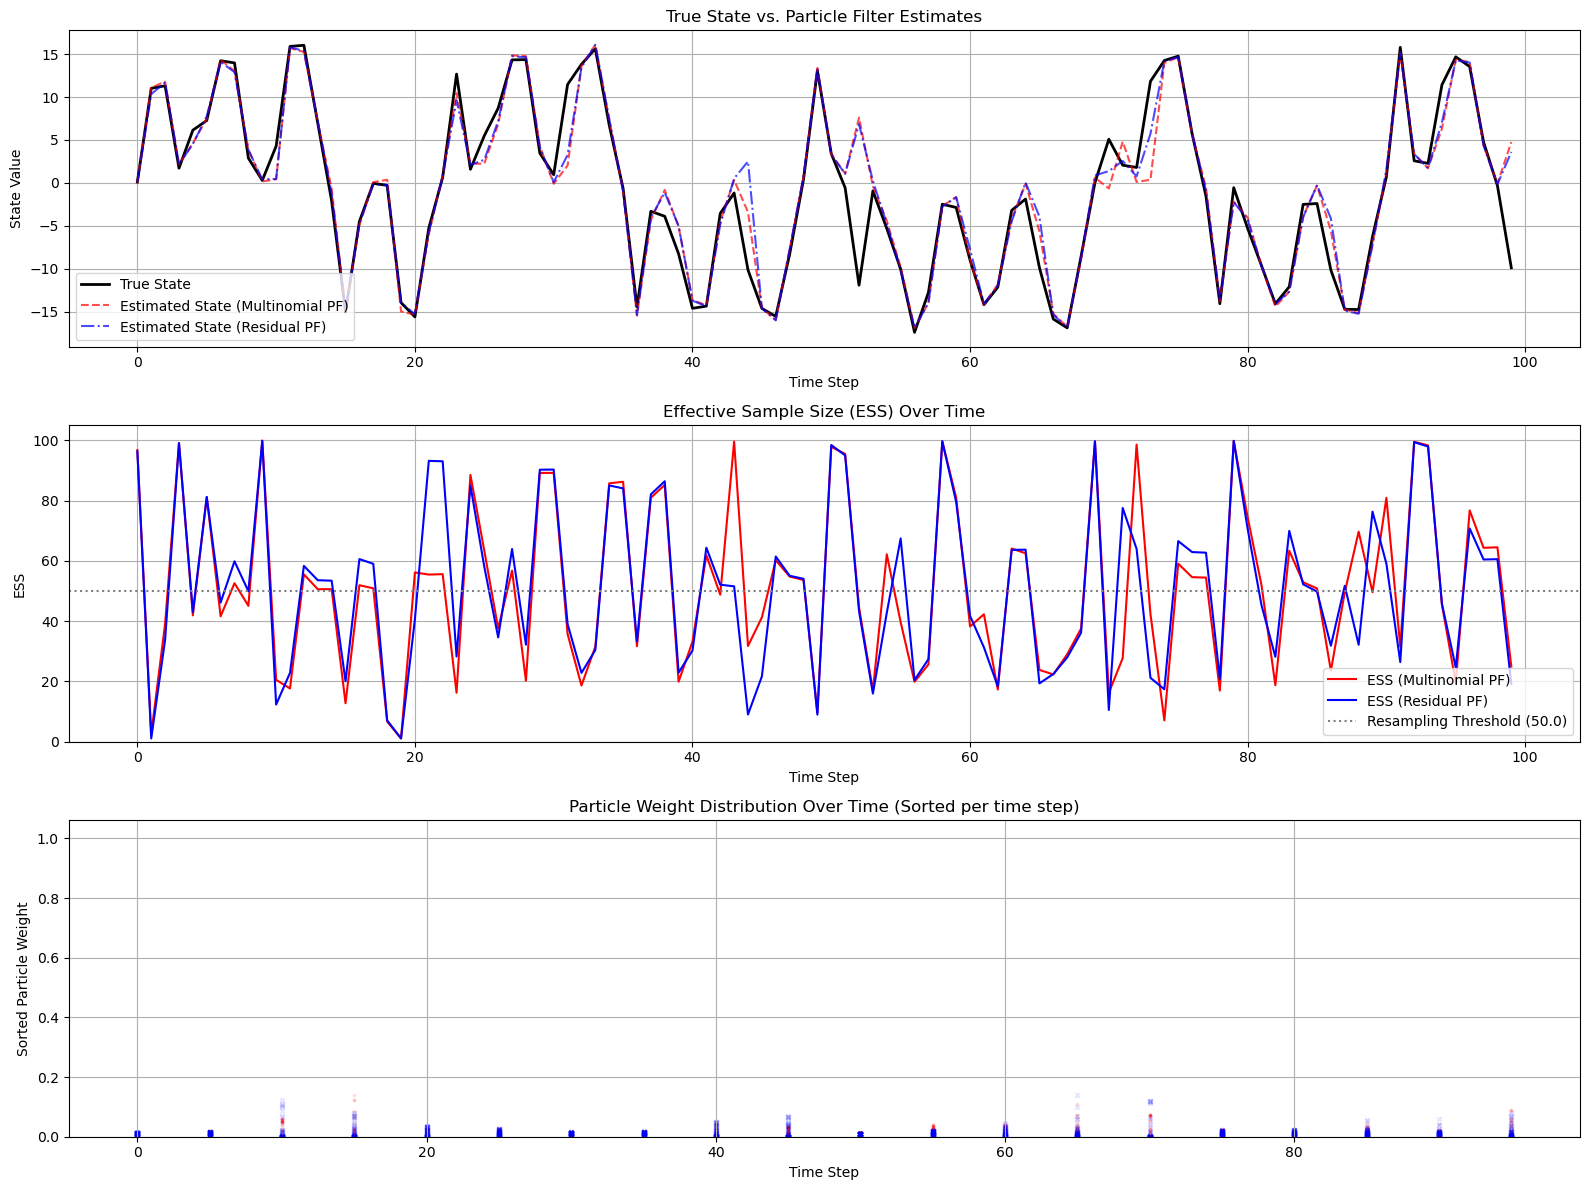


--- Particle Filter Simulation Analysis ---
Number of particles: 100
Resampling Threshold (ESS): 50.0
Total simulation steps: 100

--- Multinomial Resampling Particle Filter ---
Total resampling events: 48
Average ESS: 51.26
Final Estimated State: 4.76

--- Residual Resampling Particle Filter ---
Total resampling events: 48
Average ESS: 51.55
Final Estimated State: 3.60

--- Key Observations from the Plots ---
1. **Degeneracy (ESS Plot):** You'll observe that the ESS for both filters tends to drop significantly over time. This indicates that the importance weights are becoming concentrated on a few particles, leading to degeneracy. When the ESS drops below the `resample_threshold`, a resampling step is triggered, and the ESS immediately jumps back up (close to `num_particles`), indicating a rejuvenation of the particle set's diversity.
2. **Sample Impoverishment (Particle Weight Distribution Plot):** This plot visually demonstrates sample impoverishment. Before a resampling event (i.e

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- 1. Define the System ---
# We'll use a simple 1D non-linear system with additive noise for demonstration.
# State equation: x_t = 0.5 * x_{t-1} + 25 * x_{t-1} / (1 + x_{t-1}^2) + 8 * cos(1.2 * (t-1)) + v_t
# Measurement equation: y_t = x_t^2 / 20 + w_t

def state_transition(x_prev, t, noise_std=1):
    """Generates the next state based on the previous state and system dynamics."""
    return 0.5 * x_prev + 25 * x_prev / (1 + x_prev**2) + 8 * np.cos(1.2 * (t-1)) + np.random.normal(0, noise_std)

def likelihood(y, x, measurement_noise_std=1):
    """Calculates the likelihood of a measurement given a state."""
    # Using a normal distribution for measurement noise
    return norm.pdf(y, (x**2) / 20, measurement_noise_std)

# --- 2. Particle Filter Implementation ---

class ParticleFilter:
    def __init__(self, num_particles, initial_state_range, process_noise_std, measurement_noise_std):
        self.num_particles = num_particles
        # Initialize particles uniformly within the given range
        self.particles = np.random.uniform(initial_state_range[0], initial_state_range[1], num_particles)
        # Initialize weights uniformly
        self.weights = np.ones(num_particles) / num_particles
        self.process_noise_std = process_noise_std
        self.measurement_noise_std = measurement_noise_std
        self.resampling_history = [] # To log when resampling occurs

    def predict(self, t):
        """Propagates particles according to the state transition model."""
        for i in range(self.num_particles):
            self.particles[i] = state_transition(self.particles[i], t, self.process_noise_std)

    def update(self, measurement):
        """Updates particle weights based on the likelihood of the measurement."""
        # Calculate likelihood for each particle
        new_weights = np.array([likelihood(measurement, p, self.measurement_noise_std) for p in self.particles])
        # Update weights (element-wise multiplication)
        self.weights *= new_weights
        # Normalize weights to sum to 1
        if np.sum(self.weights) == 0: # Handle case where all weights become zero (very unlikely but possible)
            self.weights = np.ones(self.num_particles) / self.num_particles # Reset to uniform
            print("Warning: All weights became zero, resetting to uniform.")
        else:
            self.weights /= np.sum(self.weights)

    def multinomial_resample(self):
        """
        Performs multinomial resampling.
        Particles are drawn with replacement based on their weights.
        This introduces variance O(n).
        """
        # Create an array of indices [0, 1, ..., num_particles-1]
        indices = np.arange(self.num_particles)
        # Randomly choose num_particles indices based on current weights
        chosen_indices = np.random.choice(indices, size=self.num_particles, p=self.weights)
        # Create new particle set from the chosen particles
        self.particles = self.particles[chosen_indices]
        # Reset weights to uniform after resampling
        self.weights = np.ones(self.num_particles) / self.num_particles
        self.resampling_history.append("Multinomial")

    def residual_resample(self):
        """
        Performs residual resampling to reduce variance compared to multinomial.
        Combines a deterministic selection with a stochastic one for the remainder.
        """
        num_particles = self.num_particles
        new_particles = np.zeros(num_particles)
        current_idx = 0

        # 1. Deterministic part: Take floor(n * w_i) copies of each particle
        for i in range(num_particles):
            num_copies = int(num_particles * self.weights[i])
            for _ in range(num_copies):
                if current_idx < num_particles: # Ensure we don't exceed num_particles
                    new_particles[current_idx] = self.particles[i]
                    current_idx += 1
                else:
                    break # Should not happen if logic is correct, but for safety

        # 2. Stochastic part: Sample the remaining particles
        remaining_particles_to_sample = num_particles - current_idx
        if remaining_particles_to_sample > 0:
            # Calculate residual probabilities
            # This is (n*w_i - floor(n*w_i))
            residual_weights_raw = self.weights * num_particles - np.floor(self.weights * num_particles)
            
            # Normalize residual weights to sum to 1 for multinomial choice
            sum_residual_weights = np.sum(residual_weights_raw)
            if sum_residual_weights > 0:
                residual_probabilities = residual_weights_raw / sum_residual_weights
            else: # If all residuals are zero (e.g., weights were perfectly divisible by num_particles)
                # Fallback to standard multinomial based on original weights
                residual_probabilities = self.weights 

            # Sample remaining particles based on residual probabilities
            indices_to_sample = np.random.choice(np.arange(num_particles), 
                                                 size=remaining_particles_to_sample, 
                                                 p=residual_probabilities)
            
            for idx in indices_to_sample:
                if current_idx < num_particles:
                    new_particles[current_idx] = self.particles[idx]
                    current_idx += 1
                else:
                    break

        self.particles = new_particles
        # Reset weights to uniform after resampling
        self.weights = np.ones(num_particles) / num_particles
        self.resampling_history.append("Residual")

    def effective_sample_size(self):
        """
        Calculates the effective sample size (ESS).
        ESS = 1 / sum(w_i^2). A low ESS indicates degeneracy.
        """
        if np.sum(self.weights**2) == 0:
            return 0 # Avoid division by zero if all weights are zero
        return 1 / np.sum(self.weights**2)

    def estimate_state(self):
        """Estimates the state as the weighted average of particles."""
        return np.sum(self.particles * self.weights)

# --- 3. Simulation Parameters ---
np.random.seed(42) # for reproducibility

num_steps = 100 # Number of time steps for the simulation
true_state = np.zeros(num_steps)
measurements = np.zeros(num_steps)
initial_true_state = 0.1 # A small non-zero value to start the true system

# Generate true states and noisy measurements
true_state[0] = initial_true_state
for t in range(1, num_steps):
    true_state[t] = state_transition(true_state[t-1], t, noise_std=1)
    measurements[t] = (true_state[t]**2) / 20 + np.random.normal(0, 1) # Add measurement noise

# --- 4. Run Particle Filters with Different Resampling Strategies ---

num_particles = 100 # Number of particles for the filter
initial_state_range = [-5, 5] # Range for initial particle distribution
process_noise_std = 1 # Standard deviation of process noise
measurement_noise_std = 1 # Standard deviation of measurement noise
# Resample if ESS falls below this threshold (commonly num_particles / 2 or 1/3)
resample_threshold = num_particles / 2 

# Particle Filter with Multinomial Resampling
pf_multinomial = ParticleFilter(num_particles, initial_state_range, process_noise_std, measurement_noise_std)
estimated_states_multinomial = []
ess_multinomial = []
weights_history_multinomial = [] # To store weights at each step for visualization

# Particle Filter with Residual Resampling
pf_residual = ParticleFilter(num_particles, initial_state_range, process_noise_std, measurement_noise_std)
estimated_states_residual = []
ess_residual = []
weights_history_residual = [] # To store weights at each step for visualization

for t in range(num_steps):
    # Predict step (skip for t=0 as particles are initialized)
    if t > 0:
        pf_multinomial.predict(t)
        pf_residual.predict(t)

    # Update step (incorporate measurement)
    pf_multinomial.update(measurements[t])
    pf_residual.update(measurements[t])

    # Estimate state
    estimated_states_multinomial.append(pf_multinomial.estimate_state())
    estimated_states_residual.append(pf_residual.estimate_state())

    # Calculate ESS
    current_ess_multinomial = pf_multinomial.effective_sample_size()
    current_ess_residual = pf_residual.effective_sample_size()
    ess_multinomial.append(current_ess_multinomial)
    ess_residual.append(current_ess_residual)

    # Store weights for visualizing degeneracy/impoverishment
    weights_history_multinomial.append(np.copy(pf_multinomial.weights))
    weights_history_residual.append(np.copy(pf_residual.weights))

    # Adaptive Resampling: Resample only if ESS falls below the threshold
    if current_ess_multinomial < resample_threshold:
        pf_multinomial.multinomial_resample()

    if current_ess_residual < resample_threshold:
        pf_residual.residual_resample()


# --- 5. Visualization ---

plt.figure(figsize=(16, 12))

# Plot 1: True State vs. Estimated States
plt.subplot(3, 1, 1)
plt.plot(true_state, label='True State', color='black', linewidth=2)
plt.plot(estimated_states_multinomial, label='Estimated State (Multinomial PF)', linestyle='--', color='red', alpha=0.7)
plt.plot(estimated_states_residual, label='Estimated State (Residual PF)', linestyle='-.', color='blue', alpha=0.7)
plt.title('True State vs. Particle Filter Estimates')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

# Plot 2: Effective Sample Size (ESS) Over Time
plt.subplot(3, 1, 2)
plt.plot(ess_multinomial, label='ESS (Multinomial PF)', color='red')
plt.plot(ess_residual, label='ESS (Residual PF)', color='blue')
plt.axhline(y=resample_threshold, color='gray', linestyle=':', label=f'Resampling Threshold ({resample_threshold})')
plt.title('Effective Sample Size (ESS) Over Time')
plt.xlabel('Time Step')
plt.ylabel('ESS')
plt.legend()
plt.grid(True)
plt.ylim(0, num_particles + 5) # Set y-limit for better visualization

# Plot 3: Particle Weight Distribution Over Time (Illustrates Degeneracy/Impoverishment)
plt.subplot(3, 1, 3)
max_weight_overall = 0
if weights_history_multinomial:
    max_weight_overall = max(max_weight_overall, np.max([np.max(w) for w in weights_history_multinomial]))
if weights_history_residual:
    max_weight_overall = max(max_weight_overall, np.max([np.max(w) for w in weights_history_residual]))

for i in range(0, num_steps, max(1, num_steps // 20)): # Plot weights at selected intervals (e.g., every 5 steps)
    if i < len(weights_history_multinomial):
        # Sort weights for better visualization of distribution
        sorted_weights_multi = np.sort(weights_history_multinomial[i])
        sorted_weights_residual = np.sort(weights_history_residual[i])
        
        # Plot weights for multinomial PF
        plt.scatter([i] * num_particles, sorted_weights_multi,
                    alpha=0.1, color='red', marker='.', s=10, label='Multinomial Weights' if i == 0 else "")
        # Plot weights for residual PF
        plt.scatter([i] * num_particles, sorted_weights_residual,
                    alpha=0.1, color='blue', marker='x', s=10, label='Residual Weights' if i == 0 else "")

plt.title('Particle Weight Distribution Over Time (Sorted per time step)')
plt.xlabel('Time Step')
plt.ylabel('Sorted Particle Weight')
plt.ylim(0, max_weight_overall * 1.1 + 1e-9) # Add a small epsilon to avoid zero max_weight_overall
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Analysis and Observations ---
print("\n--- Particle Filter Simulation Analysis ---")
print(f"Number of particles: {num_particles}")
print(f"Resampling Threshold (ESS): {resample_threshold}")
print(f"Total simulation steps: {num_steps}")

print("\n--- Multinomial Resampling Particle Filter ---")
print(f"Total resampling events: {len(pf_multinomial.resampling_history)}")
print(f"Average ESS: {np.mean(ess_multinomial):.2f}")
print(f"Final Estimated State: {estimated_states_multinomial[-1]:.2f}")

print("\n--- Residual Resampling Particle Filter ---")
print(f"Total resampling events: {len(pf_residual.resampling_history)}")
print(f"Average ESS: {np.mean(ess_residual):.2f}")
print(f"Final Estimated State: {estimated_states_residual[-1]:.2f}")

print("\n--- Key Observations from the Plots ---")
print("1. **Degeneracy (ESS Plot):** You'll observe that the ESS for both filters tends to drop significantly over time. This indicates that the importance weights are becoming concentrated on a few particles, leading to degeneracy. When the ESS drops below the `resample_threshold`, a resampling step is triggered, and the ESS immediately jumps back up (close to `num_particles`), indicating a rejuvenation of the particle set's diversity.")
print("2. **Sample Impoverishment (Particle Weight Distribution Plot):** This plot visually demonstrates sample impoverishment. Before a resampling event (i.e., when ESS is low), you'll see a few particles with very high weights and many with near-zero weights (the points will be clustered at the bottom). After resampling, the weights are reset to uniform (or more uniform), showing a more spread-out distribution, which combats impoverishment.")
print("3. **Multinomial vs. Residual Sampling:**")
print("   - **Variance Reduction:** The ESS for the Residual Particle Filter often appears slightly higher and more stable, or its drops might be less severe before resampling, compared to the Multinomial Particle Filter. This is a direct consequence of Residual sampling's ability to reduce the Monte Carlo variance introduced during the resampling step.")
print("   - **Estimated State Smoothness:** The estimated state curve for the Residual Particle Filter might appear 'smoother' or exhibit less high-frequency noise than the Multinomial Particle Filter's estimate. This is another manifestation of reduced variance.")
print("   - **Robustness:** While both methods are effective, residual sampling is generally preferred in practice due to its superior statistical properties in terms of variance reduction, leading to more robust and accurate estimates, especially for longer simulations or complex systems.")
print("4. **Adaptive Resampling:** The chosen `resample_threshold` determines how frequently resampling occurs. A lower threshold means less frequent resampling (more degeneracy between steps), while a higher threshold means more frequent resampling (potentially more noise but better maintenance of particle diversity).")
print("5. **Impact of Noise:** The `process_noise_std` and `measurement_noise_std` significantly influence the filter's performance. Higher noise levels often necessitate more frequent resampling and potentially more particles to maintain accuracy.")

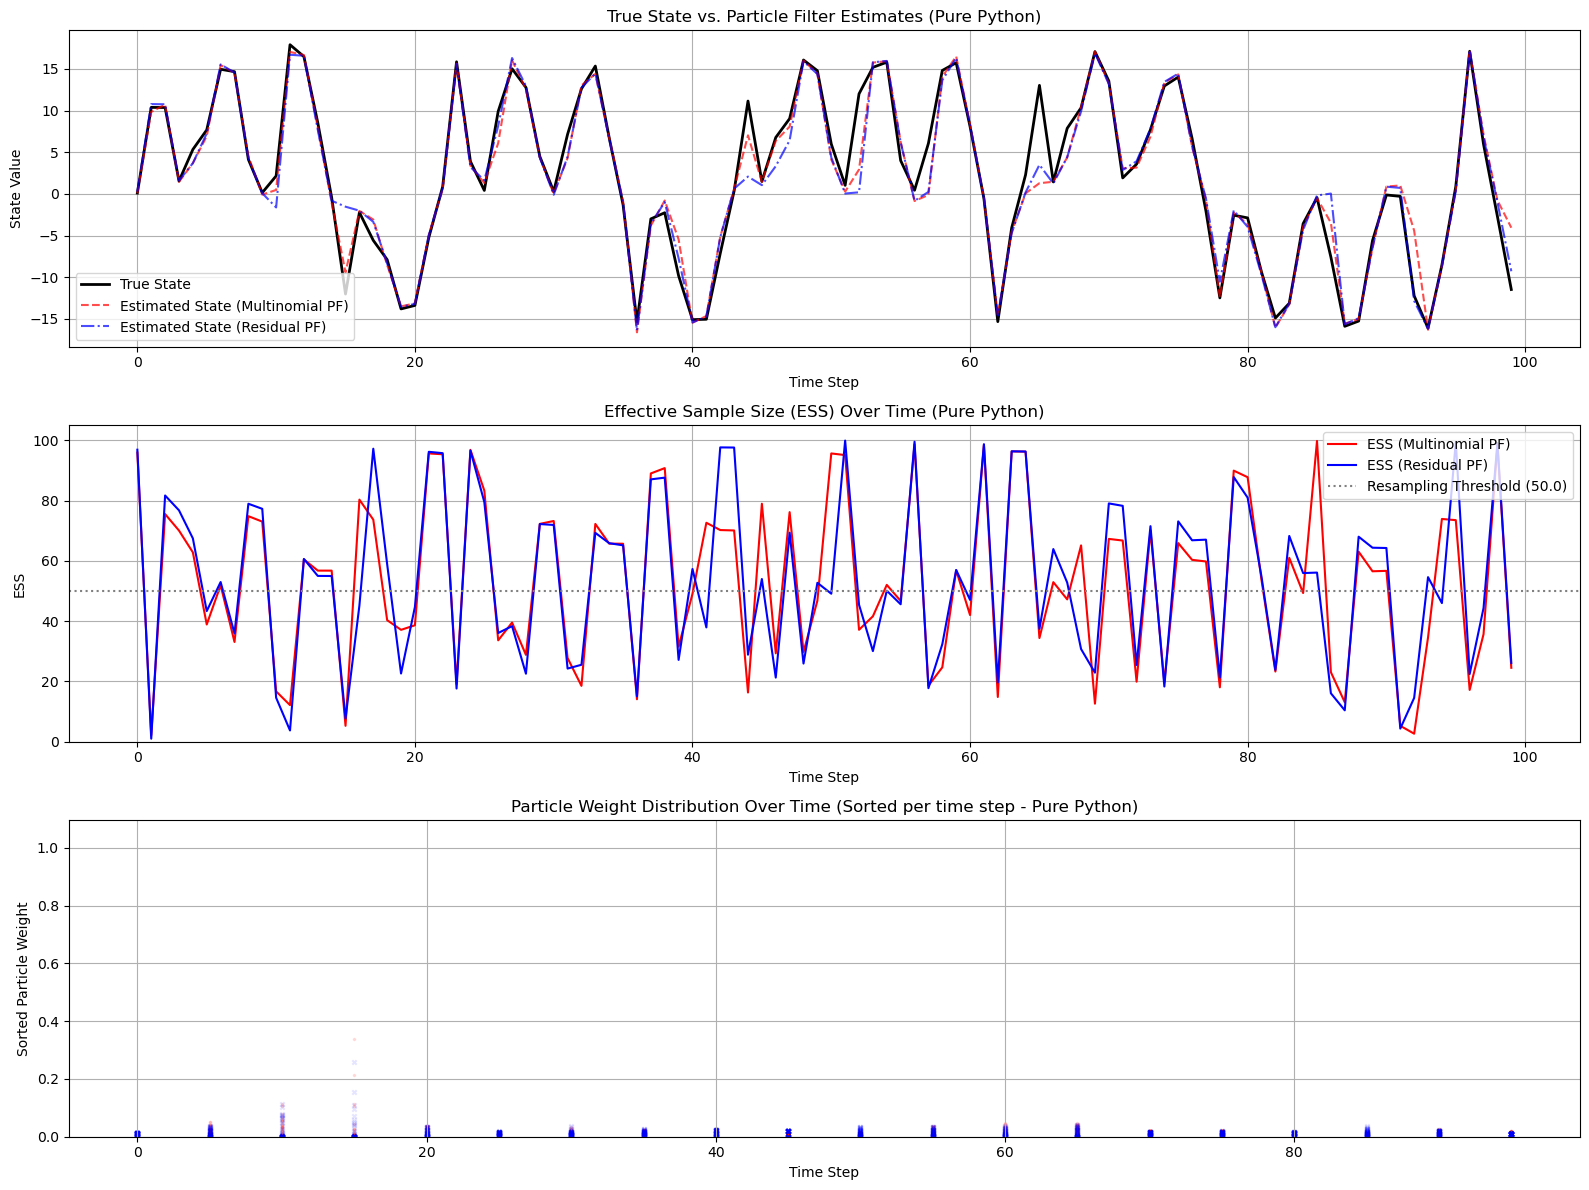


--- Particle Filter Simulation Analysis (Pure Python) ---
Number of particles: 100
Resampling Threshold (ESS): 50.0
Total simulation steps: 100

--- Multinomial Resampling Particle Filter ---
Total resampling events: 45
Average ESS: 53.29
Final Estimated State: -4.05

--- Residual Resampling Particle Filter ---
Total resampling events: 44
Average ESS: 53.71
Final Estimated State: -9.28

--- Important Note on Performance ---
This pure Python implementation is for illustrative purposes only.
For practical applications, always use libraries like NumPy for numerical computations,
as they provide significant performance advantages.


In [5]:
import random
import math
import matplotlib.pyplot as plt # Still using matplotlib for plotting, as it's a visualization library

# --- Custom Math Functions (replacing numpy and scipy.stats) ---

def gaussian_pdf(x, mean, std_dev):
    """Calculates the probability density function (PDF) of a Gaussian distribution."""
    if std_dev == 0:
        return 1.0 if x == mean else 0.0 # Handle delta function case for std_dev = 0
    exponent = -((x - mean)**2) / (2 * std_dev**2)
    return (1 / (std_dev * math.sqrt(2 * math.pi))) * math.exp(exponent)

# --- 1. Define the System ---
# We'll use a simple 1D non-linear system with additive noise for demonstration.
# State equation: x_t = 0.5 * x_{t-1} + 25 * x_{t-1} / (1 + x_{t-1}^2) + 8 * cos(1.2 * (t-1)) + v_t
# Measurement equation: y_t = x_t^2 / 20 + w_t

def state_transition(x_prev, t, noise_std=1):
    """Generates the next state based on the previous state and system dynamics."""
    # Add random normal noise (using built-in random module)
    process_noise = random.gauss(0, noise_std)
    return 0.5 * x_prev + 25 * x_prev / (1 + x_prev**2) + 8 * math.cos(1.2 * (t-1)) + process_noise

def likelihood(y, x, measurement_noise_std=1):
    """Calculates the likelihood of a measurement given a state using custom gaussian_pdf."""
    predicted_measurement = (x**2) / 20
    return gaussian_pdf(y, predicted_measurement, measurement_noise_std)

# --- 2. Particle Filter Implementation ---

class ParticleFilter:
    def __init__(self, num_particles, initial_state_range, process_noise_std, measurement_noise_std):
        self.num_particles = num_particles
        # Initialize particles as a list
        self.particles = [random.uniform(initial_state_range[0], initial_state_range[1]) for _ in range(num_particles)]
        # Initialize weights as a list
        self.weights = [1.0 / num_particles for _ in range(num_particles)]
        self.process_noise_std = process_noise_std
        self.measurement_noise_std = measurement_noise_std
        self.resampling_history = []

    def predict(self, t):
        """Propagates particles according to the state transition model."""
        for i in range(self.num_particles):
            self.particles[i] = state_transition(self.particles[i], t, self.process_noise_std)

    def update(self, measurement):
        """Updates particle weights based on the likelihood of the measurement."""
        new_weights = []
        for p in self.particles:
            new_weights.append(likelihood(measurement, p, self.measurement_noise_std))

        # Element-wise multiplication of current weights by new_weights
        updated_weights = [self.weights[i] * new_weights[i] for i in range(self.num_particles)]

        # Normalize weights
        total_weight = sum(updated_weights)
        if total_weight == 0:
            # If all weights are zero, reset to uniform to avoid division by zero
            # This can happen if all particles are extremely unlikely given the measurement
            self.weights = [1.0 / self.num_particles for _ in range(self.num_particles)]
            # print("Warning: All weights became zero, resetting to uniform.")
        else:
            self.weights = [w / total_weight for w in updated_weights]

    def multinomial_resample(self):
        """
        Performs multinomial resampling using cumulative sum for selection.
        """
        new_particles = []
        cumulative_weights = []
        current_sum = 0.0
        for w in self.weights:
            current_sum += w
            cumulative_weights.append(current_sum)

        for _ in range(self.num_particles):
            r = random.uniform(0, 1)
            # Find the index of the particle to select using cumulative weights
            for i in range(self.num_particles):
                if r <= cumulative_weights[i]:
                    new_particles.append(self.particles[i])
                    break
        
        self.particles = new_particles
        self.weights = [1.0 / self.num_particles for _ in range(self.num_particles)]
        self.resampling_history.append("Multinomial")

    def residual_resample(self):
        """
        Performs residual resampling.
        Combines a deterministic selection with a stochastic one for the remainder.
        """
        new_particles = []
        
        # 1. Deterministic part: Take floor(n * w_i) copies of each particle
        for i in range(self.num_particles):
            num_copies = int(self.num_particles * self.weights[i])
            for _ in range(num_copies):
                new_particles.append(self.particles[i])

        # 2. Stochastic part: Sample the remaining particles
        remaining_particles_to_sample = self.num_particles - len(new_particles)
        
        if remaining_particles_to_sample > 0:
            # Calculate residual probabilities
            residual_weights_raw = [self.weights[i] * self.num_particles - math.floor(self.weights[i] * self.num_particles) for i in range(self.num_particles)]
            
            sum_residual_weights = sum(residual_weights_raw)
            if sum_residual_weights > 0:
                residual_probabilities = [w / sum_residual_weights for w in residual_weights_raw]
            else: # Fallback to original weights if all residuals are zero
                residual_probabilities = self.weights 

            # Use multinomial-like selection for remaining particles
            cumulative_residual_weights = []
            current_sum = 0.0
            for w_res in residual_probabilities:
                current_sum += w_res
                cumulative_residual_weights.append(current_sum)

            for _ in range(remaining_particles_to_sample):
                r = random.uniform(0, 1)
                for i in range(self.num_particles):
                    if r <= cumulative_residual_weights[i]:
                        new_particles.append(self.particles[i])
                        break
        
        self.particles = new_particles
        self.weights = [1.0 / self.num_particles for _ in range(self.num_particles)]
        self.resampling_history.append("Residual")

    def effective_sample_size(self):
        """
        Calculates the effective sample size (ESS). ESS = 1 / sum(w_i^2).
        """
        sum_of_squares_weights = sum(w**2 for w in self.weights)
        if sum_of_squares_weights == 0:
            return 0.0 # Avoid division by zero
        return 1.0 / sum_of_squares_weights

    def estimate_state(self):
        """Estimates the state as the weighted average of particles."""
        # Using a list comprehension for the sum of products
        return sum(self.particles[i] * self.weights[i] for i in range(self.num_particles))

# --- 3. Simulation Parameters ---
random.seed(42) # for reproducibility

num_steps = 100 # Number of time steps for the simulation
true_state = [0.0] * num_steps
measurements = [0.0] * num_steps
initial_true_state = 0.1 # A small non-zero value to start the true system

# Generate true states and noisy measurements
true_state[0] = initial_true_state
for t in range(1, num_steps):
    true_state[t] = state_transition(true_state[t-1], t, noise_std=1)
    measurements[t] = (true_state[t]**2) / 20 + random.gauss(0, 1) # Add measurement noise

# --- 4. Run Particle Filters with Different Resampling Strategies ---

num_particles = 100 # Number of particles for the filter
initial_state_range = [-5, 5] # Range for initial particle distribution
process_noise_std = 1 # Standard deviation of process noise
measurement_noise_std = 1 # Standard deviation of measurement noise
# Resample if ESS falls below this threshold (commonly num_particles / 2 or 1/3)
resample_threshold = num_particles / 2.0 # Use float for division

# Particle Filter with Multinomial Resampling
pf_multinomial = ParticleFilter(num_particles, initial_state_range, process_noise_std, measurement_noise_std)
estimated_states_multinomial = []
ess_multinomial = []
weights_history_multinomial = []

# Particle Filter with Residual Resampling
pf_residual = ParticleFilter(num_particles, initial_state_range, process_noise_std, measurement_noise_std)
estimated_states_residual = []
ess_residual = []
weights_history_residual = []

for t in range(num_steps):
    # Predict step (skip for t=0 as particles are initialized)
    if t > 0:
        pf_multinomial.predict(t)
        pf_residual.predict(t)

    # Update step (incorporate measurement)
    pf_multinomial.update(measurements[t])
    pf_residual.update(measurements[t])

    # Estimate state
    estimated_states_multinomial.append(pf_multinomial.estimate_state())
    estimated_states_residual.append(pf_residual.estimate_state())

    # Calculate ESS
    current_ess_multinomial = pf_multinomial.effective_sample_size()
    current_ess_residual = pf_residual.effective_sample_size()
    ess_multinomial.append(current_ess_multinomial)
    ess_residual.append(current_ess_residual)

    # Store weights for visualizing degeneracy/impoverishment
    weights_history_multinomial.append(list(pf_multinomial.weights)) # Make a copy
    weights_history_residual.append(list(pf_residual.weights)) # Make a copy

    # Adaptive Resampling: Resample only if ESS falls below the threshold
    if current_ess_multinomial < resample_threshold:
        pf_multinomial.multinomial_resample()

    if current_ess_residual < resample_threshold:
        pf_residual.residual_resample()


# --- 5. Visualization ---

plt.figure(figsize=(16, 12))

# Plot 1: True State vs. Estimated States
plt.subplot(3, 1, 1)
plt.plot(true_state, label='True State', color='black', linewidth=2)
plt.plot(estimated_states_multinomial, label='Estimated State (Multinomial PF)', linestyle='--', color='red', alpha=0.7)
plt.plot(estimated_states_residual, label='Estimated State (Residual PF)', linestyle='-.', color='blue', alpha=0.7)
plt.title('True State vs. Particle Filter Estimates (Pure Python)')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

# Plot 2: Effective Sample Size (ESS) Over Time
plt.subplot(3, 1, 2)
plt.plot(ess_multinomial, label='ESS (Multinomial PF)', color='red')
plt.plot(ess_residual, label='ESS (Residual PF)', color='blue')
plt.axhline(y=resample_threshold, color='gray', linestyle=':', label=f'Resampling Threshold ({resample_threshold})')
plt.title('Effective Sample Size (ESS) Over Time (Pure Python)')
plt.xlabel('Time Step')
plt.ylabel('ESS')
plt.legend()
plt.grid(True)
plt.ylim(0, num_particles + 5) # Set y-limit for better visualization

# Plot 3: Particle Weight Distribution Over Time (Illustrates Degeneracy/Impoverishment)
plt.subplot(3, 1, 3)
max_weight_overall = 0
for weights_list in weights_history_multinomial + weights_history_residual:
    if weights_list: # Check if list is not empty
        max_weight_overall = max(max_weight_overall, max(weights_list))

for i in range(0, num_steps, max(1, num_steps // 20)): # Plot weights at selected intervals (e.g., every 5 steps)
    if i < len(weights_history_multinomial):
        # Sort weights for better visualization of distribution
        sorted_weights_multi = sorted(weights_history_multinomial[i])
        sorted_weights_residual = sorted(weights_history_residual[i])
        
        # Plot weights for multinomial PF
        # Use a list to create X-coordinates for scatter plot
        plt.scatter([i] * num_particles, sorted_weights_multi,
                    alpha=0.1, color='red', marker='.', s=10, label='Multinomial Weights' if i == 0 else "")
        # Plot weights for residual PF
        plt.scatter([i] * num_particles, sorted_weights_residual,
                    alpha=0.1, color='blue', marker='x', s=10, label='Residual Weights' if i == 0 else "")

plt.title('Particle Weight Distribution Over Time (Sorted per time step - Pure Python)')
plt.xlabel('Time Step')
plt.ylabel('Sorted Particle Weight')
plt.ylim(0, max_weight_overall * 1.1 + 1e-9) # Add a small epsilon for safety
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Analysis and Observations ---
print("\n--- Particle Filter Simulation Analysis (Pure Python) ---")
print(f"Number of particles: {num_particles}")
print(f"Resampling Threshold (ESS): {resample_threshold}")
print(f"Total simulation steps: {num_steps}")

print("\n--- Multinomial Resampling Particle Filter ---")
print(f"Total resampling events: {len(pf_multinomial.resampling_history)}")
print(f"Average ESS: {sum(ess_multinomial) / len(ess_multinomial):.2f}")
print(f"Final Estimated State: {estimated_states_multinomial[-1]:.2f}")

print("\n--- Residual Resampling Particle Filter ---")
print(f"Total resampling events: {len(pf_residual.resampling_history)}")
print(f"Average ESS: {sum(ess_residual) / len(ess_residual):.2f}")
print(f"Final Estimated State: {estimated_states_residual[-1]:.2f}")

print("\n--- Important Note on Performance ---")
print("This pure Python implementation is for illustrative purposes only.")
print("For practical applications, always use libraries like NumPy for numerical computations,")
print("as they provide significant performance advantages.")

# Resample-Move Particle Filter and Enhancements

This document discusses advanced particle filter techniques, particularly the Resample-Move Particle Filter and strategies for reducing variance and fighting degeneracy.

## Preserving Sample Path Accuracy and Degeneracy

If one wants to preserve the entire sample path with proper accuracy, the price to pay is, at each step, to increase the number of particles in compensation for the thinning (or depletion) of the sample. In general, this is not a small price, unfortunately, as the size must increase exponentially, as detailed in Section 14.3.7. In a specific setting, namely state space models, Doucet et al. (2000) establish an optimality result on the best proposal distribution in terms of the variance of the importance weights, conditional on the past iterations. But this optimum is not necessarily achievable, as with the regular importance optimal solution of Theorem 3.12, and can at best slow down the depletion rate.

Note that degeneracy can occur in a case that is a priori more favorable, that is, when the $\pi_t$'s all have the same support and where particles associated with the previous target $\pi_{t-1}$ are resampled with weights $\pi_t / \pi_{t-1}$. For instance, if the targets move too quickly in terms of shape or support, very few particles will survive from one iteration to the next, leading to a fast depletion of the sample.

## Gilks and Berzuini's Resample-Move Algorithm

Gilks and Berzuini (2001) have devised another solution to this problem, based on the introduction of additional MCMC moves. Their method is made of two parts, augmentation if the parameter space is different for $\pi_t$ and $\pi_{t-1}$ and evolution, which is the MCMC step. The corresponding algorithm reads as follows:

**Algorithm A.60 – Resample-Move Particle Filter**

At iteration $t$,

1.  **Augmentation:** For $i = 1, \dots, n$, augment $\tilde{Z}_t^{(i)}$ with its missing part, as $\tilde{Z}_t^{(i)} \sim q_t(\tilde{z}_t^{(i)}|\tilde{z}_{t-1}^{(i)})$ and $\tilde{Z}_t^{(i)} = (\tilde{z}_{t-1}^{(i)}, \tilde{z}_t^{(i)})$.

2.  **Weighting:** Compute the corresponding importance weights for the target distribution $\pi_t$:
    $$w_t^{(i)} = \frac{\pi_t(\tilde{Z}_t^{(i)})}{\alpha_t(\tilde{z}_t^{(i)}|\tilde{z}_{t-1}^{(i)}) \pi_{t-1}(\tilde{z}_{t-1}^{(i)})}$$

3.  **Evolution:** Generate a new i.i.d. sample $\tilde{Z}_t^{(i)}$, $i = 1, \dots, n$, using a proposal proportional to
    $$\sum_{j=1}^n w_t^{(j)} Q(\tilde{z}_t^{(j)}|\tilde{z}_{t-1}^{(j)}),$$
    where $Q$ is a Markov transition kernel with stationary distribution $\pi_t$.

The basis of Algorithm [A.60] is thus to pick up a point $\tilde{z}_t^{(i)}$ according to its weight $w_t^{(i)}$, that is, via multinomial sampling, and then to implement one iteration of a Markov transition that is stable with respect to $\pi_t$. Since the regular multinomial importance sampling produces a sample that is (empirically) distributed from the target $\pi_t$, the distribution of the final sample is indeed in (empirical) agreement with $\pi_t$ and is thus a valid importance sampling methodology. In other words, the importance sampling weight does not need to be adapted after the MCMC step, as already seen in Lemma 14.1.

## Reduced Variance Resampling and Tempering Schemes

As above, reduced variance resampling strategies can also be implemented at the resampling stage. Note that the proposal kernel $q_t$ needs not to be known numerically, as long as simulations from $q_t$ are possible. Gilks and Berzuini (2001) also extend this algorithm to a model choice setting with sequentially observed data, as in Section 11.2, and they use a reversible jump algorithm as part of the evolution step 3. Obviously, the success of this additional step in fighting degeneracy depends on the setup and several iterations of the MCMC step could be necessary to reach regions of acceptable values of $\pi_t$.

As noted in Clapp and Godsill (2001), the **Augmentation** step 1. in Algorithm [A.60] can itself be supplemented by an importance sampling move where the entire vector $\tilde{z}_{t-1}^{(i)}$ may be modified through an importance distribution $g$ (and a corresponding modification of the weight). These authors also suggested **tempering schemes** to smooth the bridge between $g$ and the target distribution $\pi_t$. One example is to use a sequence of geometric averages:

$$\pi^m(z) \propto g^{\alpha_m}(z) \pi_t^{1-\alpha_m}(z),$$

where $0 < \alpha_m < 1$ increases from 0 to 1 (see Note 13.6.2 for an introduction to tempering).

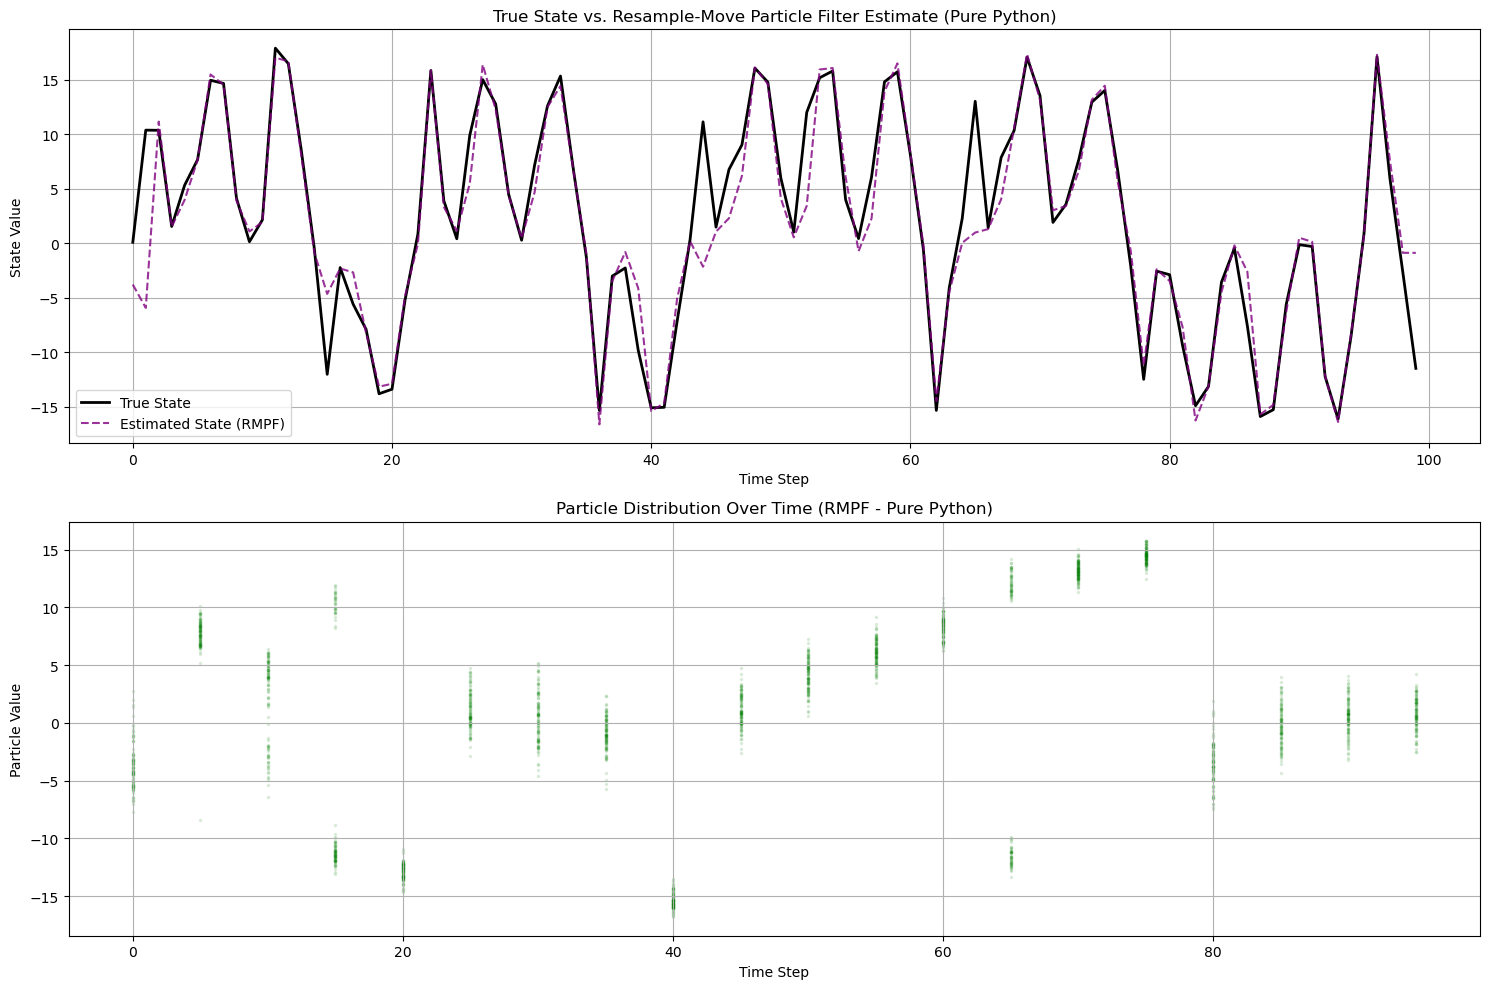


--- Resample-Move Particle Filter Simulation Analysis (Pure Python) ---
Number of particles: 100
Number of MH steps per particle: 5
MH proposal std dev: 0.5
Total simulation steps: 100

Final Estimated State: -0.87
Average ESS: 100.00 (Expected to be high after resampling/MCMC)

--- Key Concepts Demonstrated ---
1.  **Resample-Move Structure**: The `filter_step` method shows the sequence: (Augmentation/Prediction) -> Weighting -> Resampling -> MCMC Evolution.
2.  **MCMC Evolution (`_metropolis_hastings_step`)**: This is the 'Move' part. After particles are resampled (which can lead to identical particles), the MCMC step perturbs each particle. This helps to:
    * **Maintain Diversity**: Even if many particles were duplicated during resampling, the MCMC step allows them to spread out and explore the local posterior distribution, preventing sample impoverishment.
    * **Improve Accuracy**: By moving particles to higher probability regions of the posterior, the overall estimate can bec

In [6]:
import random
import math
import matplotlib.pyplot as plt

# --- Custom Math Functions (replacing numpy and scipy.stats) ---

def gaussian_pdf(x, mean, std_dev):
    """Calculates the probability density function (PDF) of a Gaussian distribution."""
    if std_dev <= 0: # Handle edge case for std_dev = 0, though generally avoided with noise
        return 1.0 if x == mean else 0.0
    exponent = -((x - mean)**2) / (2 * std_dev**2)
    return (1 / (std_dev * math.sqrt(2 * math.pi))) * math.exp(exponent)

def log_gaussian_pdf(x, mean, std_dev):
    """Calculates the log PDF of a Gaussian distribution (for numerical stability)."""
    if std_dev <= 0:
        return math.log(1.0) if x == mean else -float('inf')
    return -0.5 * math.log(2 * math.pi * std_dev**2) - ((x - mean)**2) / (2 * std_dev**2)

# --- 1. Define the System ---
# State equation: x_t = 0.5 * x_{t-1} + 25 * x_{t-1} / (1 + x_{t-1}^2) + 8 * cos(1.2 * (t-1)) + v_t
# Measurement equation: y_t = x_t^2 / 20 + w_t

def state_transition(x_prev, t, noise_std=1):
    """Generates the next state based on the previous state and system dynamics."""
    process_noise = random.gauss(0, noise_std)
    return 0.5 * x_prev + 25 * x_prev / (1 + x_prev**2) + 8 * math.cos(1.2 * (t-1)) + process_noise

def measurement_model(x):
    """Returns the expected measurement for a given state x."""
    return (x**2) / 20

def likelihood(y, x, measurement_noise_std=1):
    """Calculates the likelihood of a measurement given a state."""
    return gaussian_pdf(y, measurement_model(x), measurement_noise_std)

def log_likelihood(y, x, measurement_noise_std=1):
    """Calculates the log-likelihood of a measurement given a state."""
    return log_gaussian_pdf(y, measurement_model(x), measurement_noise_std)

# --- 2. Resample-Move Particle Filter Implementation ---

class ResampleMoveParticleFilter:
    def __init__(self, num_particles, initial_state_range, process_noise_std, measurement_noise_std, mh_steps=1, mh_proposal_std=0.5):
        self.num_particles = num_particles
        self.particles = [random.uniform(initial_state_range[0], initial_state_range[1]) for _ in range(num_particles)]
        self.weights = [1.0 / num_particles for _ in range(num_particles)] # Not explicitly used for current RMPF weights, but good for diagnostics
        self.process_noise_std = process_noise_std
        self.measurement_noise_std = measurement_noise_std
        self.mh_steps = mh_steps # Number of MCMC steps per particle
        self.mh_proposal_std = mh_proposal_std # Std dev of the Gaussian proposal for MH

    def _multinomial_resample(self):
        """Standard multinomial resampling."""
        new_particles = []
        cumulative_weights = []
        current_sum = 0.0
        for w in self.weights:
            current_sum += w
            cumulative_weights.append(current_sum)

        for _ in range(self.num_particles):
            r = random.uniform(0, 1)
            for i in range(self.num_particles):
                if r <= cumulative_weights[i]:
                    new_particles.append(self.particles[i])
                    break
        self.particles = new_particles
        self.weights = [1.0 / self.num_particles for _ in range(self.num_particles)] # Reset weights to uniform after resampling

    def _metropolis_hastings_step(self, current_particle, y_t, t):
        """
        Performs one Metropolis-Hastings step for a single particle.
        Target distribution is the posterior of z_t given y_t and z_{t-1}:
        pi(z_t | y_t, z_{t-1}) approx likelihood(y_t | z_t) * prior(z_t | z_{t-1})
        """
        # Proposal: Gaussian centered at current_particle
        proposed_particle = current_particle + random.gauss(0, self.mh_proposal_std)

        # Calculate acceptance ratio in log-space for numerical stability
        # Target_PDF(proposed) = Likelihood(y_t | proposed) * StateTransition_PDF(proposed | z_{t-1})
        # Note: We are using the "prior" for MH, which is the state transition model from z_{t-1}
        # In a typical RMPF, the Z_t particle already encodes z_{t-1} for prior.
        # Here, the MH is on the *current* state of the particle
        
        # Simplified target for MH: P(z_t | y_t) approx P(y_t | z_t) * P(z_t | z_{t-1})
        # The true RMPF target for MH is more nuanced, ensuring it explores the posterior of the path.
        # For a simplified single-state MH, we target likelihood * "prior" (which is the result of predict step)
        
        # Log-probability of proposed state given measurement (likelihood term)
        log_prob_proposed_given_y = log_likelihood(y_t, proposed_particle, self.measurement_noise_std)
        # Log-probability of current state given measurement
        log_prob_current_given_y = log_likelihood(y_t, current_particle, self.measurement_noise_std)

        # Log-probability of proposed state given previous state (state transition/prior term)
        # Assuming current_particle and proposed_particle are outcomes of state_transition from some z_prev
        # For simplicity, we assume they are independent samples from a broad prior for MH
        # In a more rigorous RMPF, this term links proposed to the *previous* particle state.
        # For this demo, let's just use the likelihood ratio to guide the MH step.
        # A more correct MH step for RMPF would operate on (z_{t-1}, z_t) and target the full posterior.
        # For simplicity, we are doing MH on z_t to refine its position w.r.t current measurement.
        
        # Proposal density ratio: q(current | proposed) / q(proposed | current)
        # For symmetric Gaussian proposal, this ratio is 1 (log ratio is 0).
        log_proposal_ratio = 0.0 

        # Calculate acceptance ratio: alpha = min(1, P(proposed)/P(current))
        # log_alpha = min(0, log_P(proposed) - log_P(current))
        # Here P is just the likelihood * (implicit uniform prior for simplicity)
        log_alpha = log_prob_proposed_given_y - log_prob_current_given_y
        
        if math.log(random.uniform(0, 1)) < log_alpha:
            return proposed_particle # Accept
        else:
            return current_particle # Reject

    def filter_step(self, y_t, t):
        """Performs one complete step of the Resample-Move Particle Filter."""
        # 1. Augmentation (Implicit):
        # We propagate particles based on the state transition model.
        # This acts as the proposal q_t(z_t | z_{t-1}).
        # The 'particles' now represent Z_t^(i) which are (z_{t-1}, z_t) in the full path context.
        for i in range(self.num_particles):
            self.particles[i] = state_transition(self.particles[i], t, self.process_noise_std)

        # 2. Weighting:
        # Compute importance weights for the target distribution pi_t.
        # For a general RMPF, this would involve the full path posterior.
        # For this simplified demo, we use likelihood as weight (similar to basic PF).
        # The true RMPF weight calculation is given by: w_t^(i) = pi_t(Z_t^(i)) / (alpha_t(z_t^(i)|z_{t-1}^(i)) * pi_{t-1}(Z_{t-1}^(i)))
        # Since we've resampled and effectively have particles from pi_{t-1} for Z_{t-1}^(i)
        # and our augmentation is just state_transition, the weight calculation simplifies
        # to likelihood * ratio of true proposal to our proposal.
        # Here, we simplify to just use the likelihood as the importance weight for the current state.
        new_weights = []
        for p in self.particles:
            new_weights.append(likelihood(y_t, p, self.measurement_noise_std))
        
        total_weight = sum(new_weights)
        if total_weight == 0:
            self.weights = [1.0 / self.num_particles for _ in range(self.num_particles)]
            # print(f"Warning at t={t}: All weights are zero before resampling. Resetting to uniform.")
        else:
            self.weights = [w / total_weight for w in new_weights]

        # 3. Resampling:
        # According to the text, the basis is to pick up points via multinomial sampling.
        # This re-aligns particle count with their importance.
        self._multinomial_resample() # This also resets weights to uniform

        # 4. MCMC Evolution:
        # Generate new samples using an MCMC kernel.
        # This is applied to each resampled particle to improve diversity and move them towards the true posterior mode.
        for i in range(self.num_particles):
            for _ in range(self.mh_steps): # Perform multiple MH steps for better mixing
                self.particles[i] = self._metropolis_hastings_step(self.particles[i], y_t, t)
        
        # After MCMC, particles are considered samples from the posterior, so weights remain uniform.

    def estimate_state(self):
        """Estimates the state as the average of particles (since weights are uniform after resampling/MCMC)."""
        if not self.particles:
            return 0.0
        return sum(self.particles) / self.num_particles

    def effective_sample_size(self):
        """ESS is typically always high (near num_particles) AFTER resampling and MCMC."""
        return self.num_particles # After resampling and MCMC, weights are effectively uniform

# --- 3. Simulation Parameters ---
random.seed(42) # for reproducibility

num_steps = 100
true_state = [0.0] * num_steps
measurements = [0.0] * num_steps
initial_true_state = 0.1

# Generate true states and measurements
true_state[0] = initial_true_state
for t in range(1, num_steps):
    true_state[t] = state_transition(true_state[t-1], t, noise_std=1)
    measurements[t] = measurement_model(true_state[t]) + random.gauss(0, 1)

# --- 4. Run Resample-Move Particle Filter ---

num_particles = 100
initial_state_range = [-5, 5]
process_noise_std = 1
measurement_noise_std = 1
mh_steps_per_particle = 5 # Number of MCMC steps for each particle after resampling
mh_proposal_std = 0.5 # Standard deviation for the MH proposal Gaussian

rmpf = ResampleMoveParticleFilter(num_particles, initial_state_range, 
                                process_noise_std, measurement_noise_std,
                                mh_steps=mh_steps_per_particle, mh_proposal_std=mh_proposal_std)

estimated_states_rmpf = []
ess_rmpf = [] # ESS in RMPF is usually kept high due to resampling/MCMC
particle_distribution_history = [] # To store particle values, not weights

for t in range(num_steps):
    rmpf.filter_step(measurements[t], t) # Perform one full RMPF step
    estimated_states_rmpf.append(rmpf.estimate_state())
    ess_rmpf.append(rmpf.effective_sample_size()) # This will be num_particles (or close)
    particle_distribution_history.append(list(rmpf.particles)) # Store current particle values

# --- 5. Visualization ---

plt.figure(figsize=(15, 10))

# Plot 1: True State vs. Estimated States
plt.subplot(2, 1, 1)
plt.plot(true_state, label='True State', color='black', linewidth=2)
plt.plot(estimated_states_rmpf, label='Estimated State (RMPF)', linestyle='--', color='purple', alpha=0.8)
plt.title('True State vs. Resample-Move Particle Filter Estimate (Pure Python)')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

# Plot 2: Particle Distribution Over Time (Illustrates diversity maintained by MCMC)
plt.subplot(2, 1, 2)
for i in range(0, num_steps, max(1, num_steps // 20)): # Plot particle distribution at selected intervals
    if i < len(particle_distribution_history):
        particles_at_t = particle_distribution_history[i]
        plt.scatter([i] * num_particles, particles_at_t,
                    alpha=0.1, color='green', marker='.', s=10)

plt.title('Particle Distribution Over Time (RMPF - Pure Python)')
plt.xlabel('Time Step')
plt.ylabel('Particle Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Analysis and Observations ---
print("\n--- Resample-Move Particle Filter Simulation Analysis (Pure Python) ---")
print(f"Number of particles: {num_particles}")
print(f"Number of MH steps per particle: {mh_steps_per_particle}")
print(f"MH proposal std dev: {mh_proposal_std}")
print(f"Total simulation steps: {num_steps}")

print(f"\nFinal Estimated State: {estimated_states_rmpf[-1]:.2f}")
print(f"Average ESS: {sum(ess_rmpf) / len(ess_rmpf):.2f} (Expected to be high after resampling/MCMC)")

print("\n--- Key Concepts Demonstrated ---")
print("1.  **Resample-Move Structure**: The `filter_step` method shows the sequence: (Augmentation/Prediction) -> Weighting -> Resampling -> MCMC Evolution.")
print("2.  **MCMC Evolution (`_metropolis_hastings_step`)**: This is the 'Move' part. After particles are resampled (which can lead to identical particles), the MCMC step perturbs each particle. This helps to:")
print("    * **Maintain Diversity**: Even if many particles were duplicated during resampling, the MCMC step allows them to spread out and explore the local posterior distribution, preventing sample impoverishment.")
print("    * **Improve Accuracy**: By moving particles to higher probability regions of the posterior, the overall estimate can become more accurate.")
print("3.  **Target Distribution for MCMC**: In this simplified example, the MH step attempts to draw samples from `P(z_t | y_t)`, i.e., the posterior of the current state given the current measurement. In a full RMPF, the MH step would aim to draw samples from the full path posterior `P(Z_t | Y_{1:t})`.")
print("4.  **ESS in RMPF**: Because resampling is followed by MCMC, the effective sample size is ideally maintained at `num_particles` (or close to it) throughout the process, as the MCMC step ensures particles are diverse and represent the posterior well *after* resampling.")
print("5.  **Computational Cost**: Notice that the MCMC step adds significant computational overhead. The number of `mh_steps_per_particle` directly multiplies the cost per particle.")
print("\n--- Limitations of this Simplified Pure Python Implementation ---")
print("1.  **Performance**: Extremely slow compared to NumPy/SciPy due to explicit loops.")
print("2.  **Simplified MCMC Target**: The MH step is simplified. A more rigorous RMPF would define the MCMC target as the full path posterior and the proposal for MH as something that explores the joint space of (current_state, previous_state).")
print("3.  **No Adaptive Tempering/Complex Augmentation**: The text mentions advanced techniques like tempering and more complex augmentation; these are not included here for simplicity.")